# Wine_Hybrid_Iterative: Iterative Truth-Biased Training

This notebook implements an iterative approach to improve hypothesis selection precision:

**Iteration 1: Unbiased Signal Extraction (same as Wine_Hybrid Phase 1)**
- Train on ALL hypotheses equally (no selection)
- Use Adaptive Context Selection to score hypotheses
- Top 30% has ~68% precision (vs 33% random baseline)

**Iteration 2: Biased Training**
- Train a NEW model on:
  - Top 30% highest-scoring samples from Iteration 1
  - Partial data with upweighting (~25% of effective training)
- This creates a "truth-biased" model (trained on >70% correct data)

**Iteration 3: Apply Biased Model to Remaining Data**
- Keep Iteration 2 model frozen
- Compute gradients AND losses on remaining 70% of data
- Theory: Truth-biased model should produce better separation signals

**Key Insight**: Once the model is biased toward correct hypotheses, loss becomes a useful signal for distinguishing correct vs incorrect hypotheses on unseen data.

In [1]:
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
from tqdm import tqdm
import sys
sys.path.insert(0, '../')
sys.path.insert(0, '../GGH')

from GGH.data_ops import DataOperator
from GGH.selection_algorithms import AlgoModulators, compute_individual_grads_nothread
from GGH.models import initialize_model, load_model
from GGH.train_val_loop import TrainValidationManager
from GGH.inspector import Inspector, visualize_train_val_error, selection_histograms
from GGH.custom_optimizer import CustomAdam
from sklearn.metrics import r2_score
from torch.autograd import grad
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

def set_to_deterministic(rand_state):
    import random
    random.seed(rand_state)
    np.random.seed(rand_state)
    torch.manual_seed(rand_state)
    torch.set_num_threads(1)
    torch.use_deterministic_algorithms(True)

print("Imports successful!")

Imports successful!


In [2]:
# Data configuration
data_path = '../data/wine/red_wine.csv'
results_path = "../saved_results/Red Wine Hybrid Iterative"
inpt_vars = ['volatile acidity', 'total sulfur dioxide', 'citric acid'] 
target_vars = ['quality']
miss_vars = ['alcohol']

# Hypothesis values (3-class)
hypothesis = [[9.4, 10.5, 12.0]]

# Model parameters
hidden_size = 32
output_size = len(target_vars)
hyp_per_sample = len(hypothesis[0])
batch_size = 100 * hyp_per_sample

# Training parameters
partial_perc = 0.025  # 2.5% complete data
rand_state = 0
lr = 0.001

# Iteration 1 parameters
iter1_epochs = 60
iter1_analysis_epochs = 5  # Track last 5 epochs

# Iteration 2 parameters
iter2_epochs = 30  # Same training duration
top_percentile = 30  # Use top 30% from Iteration 1
partial_target_ratio = 0.25  # Partial should be ~25% of effective training

# Iteration 3 parameters
iter3_analysis_epochs = 5  # Track last 5 epochs for remaining data

# Create directories
import os
os.makedirs(results_path, exist_ok=True)
for folder in ['iteration1', 'iteration2', 'iteration3']:
    os.makedirs(f'{results_path}/{folder}', exist_ok=True)

print(f"Results will be saved to: {results_path}")
print(f"Iteration 1: {iter1_epochs} epochs (track last {iter1_analysis_epochs})")
print(f"Iteration 2: {iter2_epochs} epochs on top {top_percentile}% + weighted partial")
print(f"Iteration 3: Score remaining {100-top_percentile}% with biased model")
print(f"Hypothesis values: {hypothesis[0]}")

Results will be saved to: ../saved_results/Red Wine Hybrid Iterative
Iteration 1: 60 epochs (track last 5)
Iteration 2: 30 epochs on top 30% + weighted partial
Iteration 3: Score remaining 70% with biased model
Hypothesis values: [9.4, 10.5, 12.0]


## Model Definitions

In [3]:
class HypothesisAmplifyingModel(nn.Module):
    """
    Neural network that amplifies the impact of hypothesis feature on gradients.
    
    Architecture:
    - Shared features (non-hypothesis): small embedding
    - Hypothesis feature: separate, larger embedding path
    - Concatenate and process through final layers
    """
    def __init__(self, n_shared_features, n_hypothesis_features=1, 
                 shared_hidden=16, hypothesis_hidden=32, final_hidden=32, output_size=1):
        super().__init__()
        
        # Shared features path (smaller)
        self.shared_path = nn.Sequential(
            nn.Linear(n_shared_features, shared_hidden),
            nn.ReLU(),
        )
        
        # Hypothesis feature path (larger - amplifies its importance)
        self.hypothesis_path = nn.Sequential(
            nn.Linear(n_hypothesis_features, hypothesis_hidden),
            nn.ReLU(),
            nn.Linear(hypothesis_hidden, hypothesis_hidden),
            nn.ReLU(),
        )
        
        # Combined path
        combined_size = shared_hidden + hypothesis_hidden
        self.final_path = nn.Sequential(
            nn.Linear(combined_size, final_hidden),
            nn.ReLU(),
            nn.Linear(final_hidden, output_size)
        )
        
        self.n_shared = n_shared_features
        
    def forward(self, x):
        # Split input: shared features vs hypothesis feature
        shared_features = x[:, :self.n_shared]
        hypothesis_feature = x[:, self.n_shared:]
        
        # Process separately
        shared_emb = self.shared_path(shared_features)
        hypothesis_emb = self.hypothesis_path(hypothesis_feature)
        
        # Combine and predict
        combined = torch.cat([shared_emb, hypothesis_emb], dim=1)
        return self.final_path(combined)


class StandardModel(nn.Module):
    """Standard MLP for comparison."""
    def __init__(self, input_size, hidden_size=32, output_size=1):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, output_size)
        )
    
    def forward(self, x):
        return self.net(x)

print("Models defined.")

Models defined.


## Training Classes

In [4]:
class UnbiasedTrainer:
    """
    Train on ALL hypotheses equally (no selection).
    Track per-hypothesis losses and gradients in the last N epochs.
    Used for Iteration 1.
    """
    def __init__(self, DO, model, lr=0.001, device='cpu'):
        self.DO = DO
        self.model = model
        self.device = device
        self.optimizer = torch.optim.Adam(model.parameters(), lr=lr)
        self.criterion = nn.MSELoss(reduction='none')
        self.hyp_per_sample = DO.num_hyp_comb
        
        # Tracking data
        self.loss_history = {}  # global_id -> list of losses per epoch
        self.gradient_history = {}  # global_id -> list of gradient vectors
        
    def train_epoch(self, dataloader, epoch, track_data=False):
        """Train one epoch on ALL hypotheses equally."""
        self.model.train()
        total_loss = 0
        num_batches = 0
        
        for batch_idx, (inputs, targets, global_ids) in enumerate(dataloader):
            inputs = inputs.to(self.device)
            targets = targets.to(self.device)
            
            # Standard forward pass on ALL hypotheses
            predictions = self.model(inputs)
            
            # Compute loss (mean over all hypotheses - no selection)
            individual_losses = self.criterion(predictions, targets).mean(dim=1)
            batch_loss = individual_losses.mean()
            
            # Track per-hypothesis data if in analysis window
            if track_data:
                self._track_hypothesis_data(inputs, targets, global_ids, individual_losses)
            
            # Standard backprop on ALL hypotheses
            self.optimizer.zero_grad()
            batch_loss.backward()
            self.optimizer.step()
            
            total_loss += batch_loss.item()
            num_batches += 1
        
        return total_loss / num_batches
    
    def _track_hypothesis_data(self, inputs, targets, global_ids, losses):
        """Track loss and gradient for each hypothesis in the batch."""
        self.model.eval()
        
        for i in range(len(inputs)):
            gid = global_ids[i].item()
            
            # Track loss
            if gid not in self.loss_history:
                self.loss_history[gid] = []
            self.loss_history[gid].append(losses[i].item())
            
            # Compute and track gradient for this hypothesis
            inp = inputs[i:i+1].clone().requires_grad_(True)
            pred = self.model(inp)
            loss = nn.MSELoss()(pred, targets[i:i+1])
            
            # Get gradient w.r.t. last layer weights
            params = list(self.model.parameters())
            grad_param = grad(loss, params[-2], retain_graph=False)[0]
            grad_vec = grad_param.flatten().detach().cpu().numpy()
            
            if gid not in self.gradient_history:
                self.gradient_history[gid] = []
            self.gradient_history[gid].append(grad_vec)
        
        self.model.train()
    
    def get_hypothesis_analysis(self):
        """Compile analysis results for each hypothesis."""
        analysis = {}
        
        for gid in self.loss_history:
            analysis[gid] = {
                'avg_loss': np.mean(self.loss_history[gid]),
                'loss_std': np.std(self.loss_history[gid]),
                'loss_trajectory': self.loss_history[gid],
                'avg_gradient': np.mean(self.gradient_history[gid], axis=0) if gid in self.gradient_history else None,
                'gradient_magnitude': np.mean([np.linalg.norm(g) for g in self.gradient_history.get(gid, [])]),
            }
        
        return analysis

print("UnbiasedTrainer defined.")

UnbiasedTrainer defined.


In [5]:
class BiasedTrainer:
    """
    Train on selected hypotheses + weighted partial data.
    Used for Iteration 2.
    """
    def __init__(self, DO, model, selected_gids, partial_gids, partial_weight, lr=0.001, device='cpu'):
        self.DO = DO
        self.model = model
        self.device = device
        self.optimizer = torch.optim.Adam(model.parameters(), lr=lr)
        self.criterion = nn.MSELoss(reduction='none')
        self.hyp_per_sample = DO.num_hyp_comb
        
        self.selected_gids = set(selected_gids)  # Top N% from Iteration 1
        self.partial_gids = set(partial_gids)    # Partial data (known correct)
        self.partial_weight = partial_weight
        
        # Tracking data for analysis
        self.loss_history = {}
        self.gradient_history = {}
        
    def train_epoch(self, dataloader, epoch, track_data=False):
        """Train one epoch on selected + partial data."""
        self.model.train()
        total_loss = 0
        total_weight = 0
        
        for batch_idx, (inputs, targets, global_ids) in enumerate(dataloader):
            inputs = inputs.to(self.device)
            targets = targets.to(self.device)
            
            # Compute individual losses
            predictions = self.model(inputs)
            individual_losses = self.criterion(predictions, targets).mean(dim=1)
            
            # Apply weights: selected gets weight 1, partial gets partial_weight
            weights = torch.zeros(len(inputs), device=self.device)
            included_indices = []
            
            for i, gid in enumerate(global_ids):
                gid = gid.item()
                if gid in self.partial_gids:
                    weights[i] = self.partial_weight
                    included_indices.append(i)
                elif gid in self.selected_gids:
                    weights[i] = 1.0
                    included_indices.append(i)
            
            if len(included_indices) == 0:
                continue
            
            # Weighted loss
            weighted_loss = (individual_losses * weights).sum() / weights.sum()
            
            # Track data if requested
            if track_data:
                self._track_hypothesis_data(inputs, targets, global_ids, individual_losses)
            
            # Backprop
            self.optimizer.zero_grad()
            weighted_loss.backward()
            self.optimizer.step()
            
            total_loss += weighted_loss.item() * weights.sum().item()
            total_weight += weights.sum().item()
        
        return total_loss / total_weight if total_weight > 0 else 0
    
    def _track_hypothesis_data(self, inputs, targets, global_ids, losses):
        """Track loss and gradient for each hypothesis in the batch."""
        self.model.eval()
        
        for i in range(len(inputs)):
            gid = global_ids[i].item()
            
            # Track loss
            if gid not in self.loss_history:
                self.loss_history[gid] = []
            self.loss_history[gid].append(losses[i].item())
            
            # Compute and track gradient
            inp = inputs[i:i+1].clone().requires_grad_(True)
            pred = self.model(inp)
            loss = nn.MSELoss()(pred, targets[i:i+1])
            
            params = list(self.model.parameters())
            grad_param = grad(loss, params[-2], retain_graph=False)[0]
            grad_vec = grad_param.flatten().detach().cpu().numpy()
            
            if gid not in self.gradient_history:
                self.gradient_history[gid] = []
            self.gradient_history[gid].append(grad_vec)
        
        self.model.train()
    
    def get_hypothesis_analysis(self):
        """Compile analysis results."""
        analysis = {}
        for gid in self.loss_history:
            analysis[gid] = {
                'avg_loss': np.mean(self.loss_history[gid]),
                'loss_std': np.std(self.loss_history[gid]),
                'loss_trajectory': self.loss_history[gid],
                'avg_gradient': np.mean(self.gradient_history[gid], axis=0) if gid in self.gradient_history else None,
                'gradient_magnitude': np.mean([np.linalg.norm(g) for g in self.gradient_history.get(gid, [])]),
            }
        return analysis

print("BiasedTrainer defined.")

BiasedTrainer defined.


In [6]:
class RemainingDataScorer:
    """
    Score remaining data (not used in Iteration 2) using a biased model.
    Computes both loss and gradient signals.
    Used for Iteration 3.
    """
    def __init__(self, DO, model, remaining_sample_indices, device='cpu'):
        self.DO = DO
        self.model = model
        self.device = device
        self.hyp_per_sample = DO.num_hyp_comb
        self.remaining_sample_indices = set(remaining_sample_indices)
        
        # Storage for scores
        self.loss_scores = {}  # gid -> avg_loss
        self.gradient_history = {}  # gid -> list of gradients
        
    def compute_scores(self, dataloader, n_passes=5):
        """
        Compute loss and gradient scores for remaining data.
        Run multiple passes to get stable gradient estimates.
        """
        self.model.eval()
        criterion = nn.MSELoss(reduction='none')
        
        for pass_idx in tqdm(range(n_passes), desc="Scoring passes"):
            for inputs, targets, global_ids in dataloader:
                inputs = inputs.to(self.device)
                targets = targets.to(self.device)
                
                for i in range(len(inputs)):
                    gid = global_ids[i].item()
                    sample_idx = gid // self.hyp_per_sample
                    
                    # Only score remaining samples
                    if sample_idx not in self.remaining_sample_indices:
                        continue
                    
                    # Compute loss
                    inp = inputs[i:i+1].clone().requires_grad_(True)
                    pred = self.model(inp)
                    loss = nn.MSELoss()(pred, targets[i:i+1])
                    
                    # Store loss
                    if gid not in self.loss_scores:
                        self.loss_scores[gid] = []
                    self.loss_scores[gid].append(loss.item())
                    
                    # Compute gradient
                    params = list(self.model.parameters())
                    grad_param = grad(loss, params[-2], retain_graph=False)[0]
                    grad_vec = grad_param.flatten().detach().cpu().numpy()
                    
                    if gid not in self.gradient_history:
                        self.gradient_history[gid] = []
                    self.gradient_history[gid].append(grad_vec)
        
        print(f"Scored {len(self.loss_scores)} hypotheses from {len(self.remaining_sample_indices)} samples")
    
    def get_analysis(self):
        """Get analysis for scored hypotheses."""
        analysis = {}
        for gid in self.loss_scores:
            analysis[gid] = {
                'avg_loss': np.mean(self.loss_scores[gid]),
                'loss_std': np.std(self.loss_scores[gid]),
                'avg_gradient': np.mean(self.gradient_history[gid], axis=0) if gid in self.gradient_history else None,
                'gradient_magnitude': np.mean([np.linalg.norm(g) for g in self.gradient_history.get(gid, [])]),
            }
        return analysis

print("RemainingDataScorer defined.")

RemainingDataScorer defined.


In [7]:
class HypothesisDataset(torch.utils.data.Dataset):
    """Dataset that includes global IDs for tracking."""
    def __init__(self, DO):
        # Input features = inpt_vars + hypothesis column
        input_cols = DO.inpt_vars + [f'{DO.miss_vars[0]}_hypothesis']
        self.inputs = torch.tensor(
            DO.df_train_hypothesis[input_cols].values,
            dtype=torch.float32
        )
        self.targets = torch.tensor(
            DO.df_train_hypothesis[DO.target_vars].values, 
            dtype=torch.float32
        )
        self.global_ids = torch.arange(len(self.inputs))
        self.input_cols = input_cols
        
    def __len__(self):
        return len(self.inputs)
    
    def __getitem__(self, idx):
        return self.inputs[idx], self.targets[idx], self.global_ids[idx]

print("HypothesisDataset defined.")

HypothesisDataset defined.


## Adaptive Context Selection Utilities

In [8]:
def compute_anchor_data(trainer, DO):
    """
    Compute gradient-only anchors AND enriched anchors for each class.
    Also computes anchor_similarity to decide which method to use per class.
    """
    analysis = trainer.get_hypothesis_analysis()
    hyp_per_sample = DO.num_hyp_comb
    input_cols = DO.inpt_vars
    
    # Get partial data
    partial_correct_gids = set(DO.df_train_hypothesis[
        (DO.df_train_hypothesis['partial_full_info'] == 1) & 
        (DO.df_train_hypothesis['correct_hypothesis'] == True)
    ].index.tolist())
    blacklisted_gids = set(DO.df_train_hypothesis[
        (DO.df_train_hypothesis['partial_full_info'] == 1) & 
        (DO.df_train_hypothesis['correct_hypothesis'] == False)
    ].index.tolist())
    partial_sample_indices = set(gid // hyp_per_sample for gid in partial_correct_gids)
    
    # Compute all anchors per class
    anchor_correct_grad = {}
    anchor_incorrect_grad = {}
    anchor_correct_enriched = {}
    anchor_incorrect_enriched = {}
    anchor_similarity_grad = {}
    anchor_similarity_enriched = {}
    use_enriched = {}
    
    # For normalization: collect all gradients to get scale
    all_grads = [analysis[gid]['avg_gradient'] for gid in analysis 
                 if analysis[gid]['avg_gradient'] is not None]
    grad_scale = float(np.mean([np.linalg.norm(g) for g in all_grads])) if all_grads else 1.0
    
    # Store normalization params per class
    feature_norm_params = {}
    
    for class_id in range(hyp_per_sample):
        class_correct_gids = [gid for gid in partial_correct_gids 
                              if DO.df_train_hypothesis.iloc[gid]['hyp_class_id'] == class_id]
        class_incorrect_gids = [gid for gid in blacklisted_gids 
                                if DO.df_train_hypothesis.iloc[gid]['hyp_class_id'] == class_id]
        
        # Collect gradients and features for correct
        correct_grads = []
        correct_features = []
        for gid in class_correct_gids:
            if gid in analysis and analysis[gid]['avg_gradient'] is not None:
                correct_grads.append(analysis[gid]['avg_gradient'])
                feat = DO.df_train_hypothesis.loc[gid, input_cols].values.astype(np.float64)
                correct_features.append(feat)
        
        # Collect gradients and features for incorrect
        incorrect_grads = []
        incorrect_features = []
        for gid in class_incorrect_gids:
            if gid in analysis and analysis[gid]['avg_gradient'] is not None:
                incorrect_grads.append(analysis[gid]['avg_gradient'])
                feat = DO.df_train_hypothesis.loc[gid, input_cols].values.astype(np.float64)
                incorrect_features.append(feat)
        
        if not correct_grads or not incorrect_grads:
            continue
            
        # Gradient-only anchors
        anchor_correct_grad[class_id] = np.mean(correct_grads, axis=0)
        anchor_incorrect_grad[class_id] = np.mean(incorrect_grads, axis=0)
        
        # Compute gradient-only anchor similarity
        sim_grad = float(np.dot(anchor_correct_grad[class_id], anchor_incorrect_grad[class_id]) / (
            np.linalg.norm(anchor_correct_grad[class_id]) * np.linalg.norm(anchor_incorrect_grad[class_id]) + 1e-8))
        anchor_similarity_grad[class_id] = sim_grad
        
        # Decide: use enriched if gradient anchor_similarity > 0
        use_enriched[class_id] = sim_grad > 0
        
        # Enriched anchors (gradient + normalized features)
        correct_grads = np.array(correct_grads, dtype=np.float64)
        incorrect_grads = np.array(incorrect_grads, dtype=np.float64)
        correct_features = np.array(correct_features, dtype=np.float64)
        incorrect_features = np.array(incorrect_features, dtype=np.float64)
        
        # Normalize features to gradient scale
        all_features = np.vstack([correct_features, incorrect_features])
        feat_mean = np.mean(all_features, axis=0)
        feat_std = np.std(all_features, axis=0) + 1e-8
        
        feature_norm_params[class_id] = {'mean': feat_mean, 'std': feat_std, 'scale': grad_scale}
        
        correct_features_norm = (correct_features - feat_mean) / feat_std * grad_scale
        incorrect_features_norm = (incorrect_features - feat_mean) / feat_std * grad_scale
        
        # Enriched = gradient + normalized features
        correct_enriched = np.hstack([correct_grads, correct_features_norm])
        incorrect_enriched = np.hstack([incorrect_grads, incorrect_features_norm])
        
        anchor_correct_enriched[class_id] = np.mean(correct_enriched, axis=0)
        anchor_incorrect_enriched[class_id] = np.mean(incorrect_enriched, axis=0)
        
        # Compute enriched anchor similarity
        sim_enriched = float(np.dot(anchor_correct_enriched[class_id], anchor_incorrect_enriched[class_id]) / (
            np.linalg.norm(anchor_correct_enriched[class_id]) * np.linalg.norm(anchor_incorrect_enriched[class_id]) + 1e-8))
        anchor_similarity_enriched[class_id] = sim_enriched
    
    return {
        'anchor_correct_grad': anchor_correct_grad,
        'anchor_incorrect_grad': anchor_incorrect_grad,
        'anchor_correct_enriched': anchor_correct_enriched,
        'anchor_incorrect_enriched': anchor_incorrect_enriched,
        'anchor_similarity_grad': anchor_similarity_grad,
        'anchor_similarity_enriched': anchor_similarity_enriched,
        'use_enriched': use_enriched,
        'grad_scale': grad_scale,
        'feature_norm_params': feature_norm_params,
        'partial_correct_gids': partial_correct_gids,
        'blacklisted_gids': blacklisted_gids,
        'partial_sample_indices': partial_sample_indices,
        'input_cols': input_cols
    }


def compute_adaptive_score(gradient, features, class_id, anchor_data):
    """
    Compute score using adaptive method:
    - Gradient-only for classes with good gradient separation (anchor_sim < 0)
    - Enriched (gradient + features) for classes with poor gradient separation (anchor_sim > 0)
    """
    use_enriched = anchor_data['use_enriched'].get(class_id, False)
    
    if use_enriched:
        # Use enriched vectors
        norm_params = anchor_data['feature_norm_params'].get(class_id)
        if norm_params:
            features_norm = (features - norm_params['mean']) / norm_params['std'] * norm_params['scale']
        else:
            features_norm = features
        enriched = np.concatenate([gradient, features_norm])
        
        anchor_c = anchor_data['anchor_correct_enriched'].get(class_id)
        anchor_i = anchor_data['anchor_incorrect_enriched'].get(class_id)
    else:
        # Use gradient-only
        enriched = gradient
        anchor_c = anchor_data['anchor_correct_grad'].get(class_id)
        anchor_i = anchor_data['anchor_incorrect_grad'].get(class_id)
    
    if anchor_c is None:
        return 0.0
    
    sim_c = float(np.dot(enriched, anchor_c) / (np.linalg.norm(enriched) * np.linalg.norm(anchor_c) + 1e-8))
    
    if anchor_i is not None:
        sim_i = float(np.dot(enriched, anchor_i) / (np.linalg.norm(enriched) * np.linalg.norm(anchor_i) + 1e-8))
    else:
        sim_i = 0.0
    
    return sim_c - sim_i


def print_adaptive_method_summary(anchor_data, hyp_per_sample):
    """Print summary of adaptive method selection per class."""
    print("Per-class method selection:")
    for class_id in range(hyp_per_sample):
        use_enr = anchor_data['use_enriched'].get(class_id, False)
        sim_grad = anchor_data['anchor_similarity_grad'].get(class_id, None)
        sim_enr = anchor_data['anchor_similarity_enriched'].get(class_id, None)
        
        if use_enr:
            print(f"  Class {class_id}: grad_sim={sim_grad:+.3f} (poor) -> ENRICHED (enriched_sim={sim_enr:+.3f})")
        else:
            print(f"  Class {class_id}: grad_sim={sim_grad:+.3f} (good) -> GRADIENT-ONLY")

print("Adaptive context utilities loaded.")

Adaptive context utilities loaded.


## Combined Loss + Gradient Scoring (for Iteration 3)

In [9]:
def compute_combined_score(loss, gradient, features, class_id, anchor_data, loss_weight=0.5):
    """
    Combine loss and gradient signals for scoring.
    
    For a truth-biased model:
    - Lower loss = more likely correct (aligned with truth)
    - Gradient similarity to correct anchor = more likely correct
    
    Final score = (1 - loss_weight) * gradient_score + loss_weight * (-normalized_loss)
    Higher score = more likely correct
    """
    # Gradient score (same as adaptive)
    grad_score = compute_adaptive_score(gradient, features, class_id, anchor_data)
    
    # Loss score: lower loss = higher score
    # We'll normalize this later when we have all losses
    loss_score = -loss  # Negative because lower loss is better
    
    return {
        'grad_score': grad_score,
        'loss_score': loss_score,
        'raw_loss': loss
    }


def normalize_and_combine_scores(all_scores, loss_weight=0.5):
    """
    Normalize loss scores per class and combine with gradient scores.
    
    Returns combined scores where higher = more likely correct.
    """
    # Group by class
    class_losses = {}
    for sample_idx, (gid, scores) in all_scores.items():
        class_id = scores['class_id']
        if class_id not in class_losses:
            class_losses[class_id] = []
        class_losses[class_id].append(scores['raw_loss'])
    
    # Compute per-class mean and std for loss normalization
    class_stats = {}
    for class_id, losses in class_losses.items():
        class_stats[class_id] = {
            'mean': np.mean(losses),
            'std': np.std(losses) + 1e-8
        }
    
    # Normalize and combine
    combined_scores = {}
    for sample_idx, (gid, scores) in all_scores.items():
        class_id = scores['class_id']
        stats = class_stats[class_id]
        
        # Z-score normalize loss (then negate: lower loss = higher score)
        normalized_loss_score = -(scores['raw_loss'] - stats['mean']) / stats['std']
        
        # Combine: weighted average of gradient and loss scores
        combined = (1 - loss_weight) * scores['grad_score'] + loss_weight * normalized_loss_score
        
        combined_scores[sample_idx] = {
            'gid': gid,
            'combined_score': combined,
            'grad_score': scores['grad_score'],
            'loss_score': normalized_loss_score,
            'raw_loss': scores['raw_loss'],
            'class_id': class_id,
            'is_correct': scores['is_correct']
        }
    
    return combined_scores

print("Combined scoring utilities loaded.")

Combined scoring utilities loaded.


## Analysis Utilities

In [10]:
def analyze_threshold_precision(all_selections, title="Precision Analysis", verbose=True):
    """
    Analyze precision at different thresholds.
    
    all_selections: list of (score, is_correct, sample_idx) tuples, sorted by score descending
    """
    if not all_selections:
        print("No selections to analyze")
        return None, None
    
    # Compute precision at different percentiles
    results = []
    percentiles = [10, 20, 30, 40, 50, 60, 70, 80, 90, 100]
    
    for pct in percentiles:
        n_include = max(1, int(len(all_selections) * pct / 100))
        top_selections = all_selections[:n_include]
        n_correct = sum(1 for _, is_correct, _ in top_selections if is_correct)
        precision = n_correct / n_include
        results.append({
            'percentile': pct,
            'n_samples': n_include,
            'n_correct': n_correct,
            'precision': precision
        })
    
    # Compute precision in score bins
    scores = [s[0] for s in all_selections]
    min_score, max_score = min(scores), max(scores)
    n_bins = 10
    bin_results = []
    
    for i in range(n_bins):
        bin_low = min_score + (max_score - min_score) * i / n_bins
        bin_high = min_score + (max_score - min_score) * (i + 1) / n_bins
        bin_selections = [(s, c) for s, c, _ in all_selections if bin_low <= s < bin_high]
        if bin_selections:
            bin_correct = sum(1 for _, c in bin_selections if c)
            bin_results.append({
                'bin': f'{bin_low:.2f}-{bin_high:.2f}',
                'n_samples': len(bin_selections),
                'precision': bin_correct / len(bin_selections)
            })
    
    if verbose:
        print("=" * 70)
        print(title)
        print("=" * 70)
        
        print("\nPrecision by Top Percentile (highest scores first):")
        print("-" * 50)
        for r in results:
            print(f"Top {r['percentile']:>3}%: {r['n_samples']:>4} samples, precision={r['precision']*100:.1f}%")
        
        if bin_results:
            print("\nPrecision by Score Bin:")
            print("-" * 50)
            for r in bin_results:
                print(f"Score {r['bin']}: {r['n_samples']:>4} samples, precision={r['precision']*100:.1f}%")
    
    return results, bin_results


def select_hypotheses_adaptive(trainer, DO, anchor_data=None):
    """
    Select best hypothesis per sample using adaptive context.
    Returns list of (score, is_correct, sample_idx) sorted by score descending.
    """
    if anchor_data is None:
        anchor_data = compute_anchor_data(trainer, DO)
    
    analysis = trainer.get_hypothesis_analysis()
    hyp_per_sample = DO.num_hyp_comb
    n_samples = len(DO.df_train_hypothesis) // hyp_per_sample
    input_cols = anchor_data['input_cols']
    
    partial_sample_indices = anchor_data['partial_sample_indices']
    blacklisted_gids = anchor_data['blacklisted_gids']
    
    all_selections = []
    
    for sample_idx in range(n_samples):
        if sample_idx in partial_sample_indices:
            continue
        
        start = sample_idx * hyp_per_sample
        best_score = -np.inf
        best_is_correct = False
        best_gid = None
        
        for hyp_idx in range(hyp_per_sample):
            gid = start + hyp_idx
            if gid in blacklisted_gids:
                continue
            if gid not in analysis or analysis[gid]['avg_gradient'] is None:
                continue
            
            gradient = analysis[gid]['avg_gradient']
            class_id = DO.df_train_hypothesis.iloc[gid]['hyp_class_id']
            features = DO.df_train_hypothesis.loc[gid, input_cols].values.astype(np.float64)
            
            score = compute_adaptive_score(gradient, features, class_id, anchor_data)
            
            if score > best_score:
                best_score = score
                best_is_correct = DO.df_train_hypothesis.iloc[gid]['correct_hypothesis']
                best_gid = gid
        
        if best_score > -np.inf:
            all_selections.append((best_score, best_is_correct, sample_idx, best_gid))
    
    # Sort by score descending
    all_selections.sort(key=lambda x: x[0], reverse=True)
    
    return all_selections, anchor_data

print("Analysis utilities loaded.")

Analysis utilities loaded.


---
# ITERATION 1: Unbiased Training

Train on ALL hypotheses equally. No selection = no feedback loop bias.
Use Adaptive Context Selection to score hypotheses.

In [11]:
# Initialize data
set_to_deterministic(rand_state)

DO = DataOperator(data_path, inpt_vars, target_vars, miss_vars, hypothesis,
                  partial_perc, rand_state, device='cpu')
DO.problem_type = 'regression'

print(f"Lack partial coverage: {DO.lack_partial_coverage}")
print(f"Number of training hypotheses: {len(DO.df_train_hypothesis)}")
print(f"Hypotheses per sample: {DO.num_hyp_comb}")
print(f"Number of samples: {len(DO.df_train_hypothesis) // DO.num_hyp_comb}")

# Count partial data
partial_correct_gids = DO.df_train_hypothesis[
    (DO.df_train_hypothesis['partial_full_info'] == 1) & 
    (DO.df_train_hypothesis['correct_hypothesis'] == True)
].index.tolist()
print(f"Partial data samples: {len(partial_correct_gids)}")

Lack partial coverage: False
Number of training hypotheses: 3453
Hypotheses per sample: 3
Number of samples: 1151
Partial data samples: 28


In [12]:
if not DO.lack_partial_coverage:
    # Create dataloader
    dataset = HypothesisDataset(DO)
    dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True)
    
    # Check input structure
    input_size = dataset.inputs.shape[1]
    n_shared_features = len(inpt_vars)
    n_hypothesis_features = 1
    
    print(f"\nInput structure:")
    print(f"  Total input size: {input_size}")
    print(f"  Shared features: {n_shared_features}")
    print(f"  Hypothesis feature: {n_hypothesis_features}")
    
    # Create model
    model_iter1 = HypothesisAmplifyingModel(
        n_shared_features=n_shared_features,
        n_hypothesis_features=n_hypothesis_features,
        shared_hidden=16,
        hypothesis_hidden=32,
        final_hidden=32,
        output_size=output_size
    )
    
    print(f"\nModel created: HypothesisAmplifyingModel")


Input structure:
  Total input size: 4
  Shared features: 3
  Hypothesis feature: 1

Model created: HypothesisAmplifyingModel


In [13]:
# Train Iteration 1
if not DO.lack_partial_coverage:
    trainer_iter1 = UnbiasedTrainer(DO, model_iter1, lr=lr)
    
    print("=" * 70)
    print("ITERATION 1: Unbiased Training")
    print("=" * 70)
    print(f"Training on ALL hypotheses equally for {iter1_epochs} epochs")
    print(f"Tracking gradients in last {iter1_analysis_epochs} epochs")
    
    iter1_losses = []
    
    for epoch in tqdm(range(iter1_epochs)):
        # Track data in last N epochs
        track = epoch >= (iter1_epochs - iter1_analysis_epochs)
        
        loss = trainer_iter1.train_epoch(dataloader, epoch, track_data=track)
        iter1_losses.append(loss)
        
        if (epoch + 1) % 20 == 0:
            status = "(tracking)" if track else ""
            print(f"Epoch {epoch+1}/{iter1_epochs}: Loss = {loss:.4f} {status}")
    
    print(f"\nIteration 1 complete. Final loss: {iter1_losses[-1]:.4f}")
    print(f"Tracked {len(trainer_iter1.loss_history)} hypotheses")

ITERATION 1: Unbiased Training
Training on ALL hypotheses equally for 60 epochs
Tracking gradients in last 5 epochs


 40%|████      | 24/60 [00:00<00:01, 29.90it/s]

Epoch 20/60: Loss = 0.0226 


 72%|███████▏  | 43/60 [00:01<00:00, 25.69it/s]

Epoch 40/60: Loss = 0.0214 


100%|██████████| 60/60 [00:07<00:00,  8.34it/s]

Epoch 60/60: Loss = 0.0214 (tracking)

Iteration 1 complete. Final loss: 0.0214
Tracked 3453 hypotheses


In [14]:
# Analyze Iteration 1 results
if not DO.lack_partial_coverage:
    # Get selections with adaptive context
    all_selections_iter1, anchor_data_iter1 = select_hypotheses_adaptive(trainer_iter1, DO)
    
    print("\n" + "=" * 70)
    print("ITERATION 1: Selection Analysis (Adaptive Context)")
    print("=" * 70)
    
    print_adaptive_method_summary(anchor_data_iter1, hyp_per_sample)
    
    # Convert to format for analysis
    selections_for_analysis = [(s[0], s[1], s[2]) for s in all_selections_iter1]
    results_iter1, _ = analyze_threshold_precision(
        selections_for_analysis, 
        title="ITERATION 1: Precision by Threshold"
    )
    
    # Store precision for comparison
    iter1_precision = {r['percentile']: r['precision'] for r in results_iter1}


ITERATION 1: Selection Analysis (Adaptive Context)
Per-class method selection:
  Class 0: grad_sim=-0.985 (good) -> GRADIENT-ONLY
  Class 1: grad_sim=+0.956 (poor) -> ENRICHED (enriched_sim=-0.396)
  Class 2: grad_sim=+0.825 (poor) -> ENRICHED (enriched_sim=-0.304)
ITERATION 1: Precision by Threshold

Precision by Top Percentile (highest scores first):
--------------------------------------------------
Top  10%:  112 samples, precision=58.9%
Top  20%:  224 samples, precision=67.4%
Top  30%:  336 samples, precision=67.6%
Top  40%:  449 samples, precision=64.8%
Top  50%:  561 samples, precision=59.9%
Top  60%:  673 samples, precision=54.2%
Top  70%:  786 samples, precision=52.0%
Top  80%:  898 samples, precision=51.8%
Top  90%: 1010 samples, precision=50.5%
Top 100%: 1123 samples, precision=48.4%

Precision by Score Bin:
--------------------------------------------------
Score -0.85--0.56:    8 samples, precision=37.5%
Score -0.56--0.28:   24 samples, precision=20.8%
Score -0.28-0.00:  

In [15]:
# Select top N% for Iteration 2
if not DO.lack_partial_coverage:
    n_total = len(all_selections_iter1)
    n_top = max(1, int(n_total * top_percentile / 100))
    
    top_selections = all_selections_iter1[:n_top]
    top_sample_indices = set(s[2] for s in top_selections)
    top_gids = set(s[3] for s in top_selections)
    
    # Remaining samples (not in top N%)
    remaining_sample_indices = set(s[2] for s in all_selections_iter1[n_top:])
    
    # Count correct in top selection
    n_correct_top = sum(1 for s in top_selections if s[1])
    precision_top = n_correct_top / n_top
    
    print(f"\n" + "=" * 70)
    print(f"ITERATION 1: Top {top_percentile}% Selection")
    print("=" * 70)
    print(f"Selected {n_top} samples (top {top_percentile}%)")
    print(f"Correct: {n_correct_top} ({precision_top*100:.1f}% precision)")
    print(f"Remaining samples: {len(remaining_sample_indices)}")


ITERATION 1: Top 30% Selection
Selected 336 samples (top 30%)
Correct: 227 (67.6% precision)
Remaining samples: 787


---
# ITERATION 2: Biased Training

Train a NEW model on:
- Top 30% from Iteration 1 (high precision selections)
- Partial data with upweighting (~25% of effective training)

This creates a "truth-biased" model.

In [16]:
if not DO.lack_partial_coverage:
    # Get partial data GIDs (correct hypotheses from partial data)
    partial_gids = set(anchor_data_iter1['partial_correct_gids'])
    n_partial = len(partial_gids)
    n_selected = len(top_gids)
    
    # Calculate weight for partial data
    # Target: partial should be ~25% of effective training
    # partial_weight * n_partial / (partial_weight * n_partial + n_selected) = 0.25
    # Solving: partial_weight = 0.25 * n_selected / (0.75 * n_partial)
    partial_weight = (partial_target_ratio * n_selected) / ((1 - partial_target_ratio) * n_partial)
    partial_weight = max(1.0, partial_weight)  # At least weight 1
    
    effective_partial = n_partial * partial_weight
    effective_total = effective_partial + n_selected
    actual_partial_ratio = effective_partial / effective_total
    
    print("=" * 70)
    print("ITERATION 2: Biased Training Setup")
    print("=" * 70)
    print(f"Training data:")
    print(f"  Selected (top {top_percentile}%): {n_selected} samples")
    print(f"  Partial data: {n_partial} samples")
    print(f"  Partial weight: {partial_weight:.2f}x")
    print(f"  Effective partial: {effective_partial:.1f} ({actual_partial_ratio*100:.1f}% of training)")
    print(f"  Effective total: {effective_total:.1f}")

ITERATION 2: Biased Training Setup
Training data:
  Selected (top 30%): 336 samples
  Partial data: 28 samples
  Partial weight: 4.00x
  Effective partial: 112.0 (25.0% of training)
  Effective total: 448.0


In [17]:
if not DO.lack_partial_coverage:
    # Create new model for Iteration 2
    set_to_deterministic(rand_state + 1)  # Different seed for variety
    
    model_iter2 = HypothesisAmplifyingModel(
        n_shared_features=n_shared_features,
        n_hypothesis_features=n_hypothesis_features,
        shared_hidden=16,
        hypothesis_hidden=32,
        final_hidden=32,
        output_size=output_size
    )
    
    # Create biased trainer
    trainer_iter2 = BiasedTrainer(
        DO, model_iter2, 
        selected_gids=top_gids,
        partial_gids=partial_gids,
        partial_weight=partial_weight,
        lr=lr
    )
    
    print("\n" + "=" * 70)
    print("ITERATION 2: Training Biased Model")
    print("=" * 70)
    
    iter2_losses = []
    
    for epoch in tqdm(range(iter2_epochs)):
        loss = trainer_iter2.train_epoch(dataloader, epoch, track_data=False)
        iter2_losses.append(loss)
        
        if (epoch + 1) % 20 == 0:
            print(f"Epoch {epoch+1}/{iter2_epochs}: Loss = {loss:.4f}")
    
    print(f"\nIteration 2 complete. Final loss: {iter2_losses[-1]:.4f}")


ITERATION 2: Training Biased Model


 80%|████████  | 24/30 [00:00<00:00, 24.93it/s]

Epoch 20/30: Loss = 0.0077


100%|██████████| 30/30 [00:01<00:00, 24.81it/s]


Iteration 2 complete. Final loss: 0.0071


---
# ITERATION 3: Score Remaining Data with Biased Model

Use the truth-biased model from Iteration 2 to score the remaining 70% of data.
Compute BOTH loss and gradient signals, then combine them.

**Key insight**: Since the model is biased toward truth:
- Correct hypotheses should have LOWER loss
- Incorrect hypotheses should have HIGHER loss
- This makes loss a useful discriminative signal

In [18]:
if not DO.lack_partial_coverage:
    print("=" * 70)
    print("ITERATION 3: Scoring Remaining Data")
    print("=" * 70)
    print(f"Scoring {len(remaining_sample_indices)} remaining samples with biased model")
    
    # Create scorer
    scorer = RemainingDataScorer(DO, model_iter2, remaining_sample_indices)
    
    # Score remaining data
    scorer.compute_scores(dataloader, n_passes=iter3_analysis_epochs)
    
    # Get analysis
    analysis_iter3 = scorer.get_analysis()

ITERATION 3: Scoring Remaining Data
Scoring 787 remaining samples with biased model


Scoring passes: 100%|██████████| 5/5 [00:03<00:00,  1.41it/s]


Scored 2361 hypotheses from 787 samples


In [19]:
if not DO.lack_partial_coverage:
    # Compute new anchors using the biased model's view of partial data
    # We need to score partial data with the biased model too
    
    print("\nComputing anchors from biased model on partial data...")
    
    # Score partial data with biased model
    partial_sample_indices = anchor_data_iter1['partial_sample_indices']
    partial_scorer = RemainingDataScorer(DO, model_iter2, partial_sample_indices)
    partial_scorer.compute_scores(dataloader, n_passes=iter3_analysis_epochs)
    
    # Build anchor data from partial scores
    partial_analysis = partial_scorer.get_analysis()
    
    # Create anchor data structure similar to compute_anchor_data
    anchor_data_iter3 = {
        'anchor_correct_grad': {},
        'anchor_incorrect_grad': {},
        'anchor_similarity_grad': {},
        'use_enriched': {},  # For now, use gradient-only for simplicity
        'input_cols': inpt_vars,
        'partial_correct_gids': anchor_data_iter1['partial_correct_gids'],
        'blacklisted_gids': anchor_data_iter1['blacklisted_gids'],
        'partial_sample_indices': partial_sample_indices,
    }
    
    # Compute anchors per class
    for class_id in range(hyp_per_sample):
        correct_grads = []
        incorrect_grads = []
        
        for gid in anchor_data_iter1['partial_correct_gids']:
            if gid in partial_analysis and DO.df_train_hypothesis.iloc[gid]['hyp_class_id'] == class_id:
                if partial_analysis[gid]['avg_gradient'] is not None:
                    correct_grads.append(partial_analysis[gid]['avg_gradient'])
        
        for gid in anchor_data_iter1['blacklisted_gids']:
            if gid in partial_analysis and DO.df_train_hypothesis.iloc[gid]['hyp_class_id'] == class_id:
                if partial_analysis[gid]['avg_gradient'] is not None:
                    incorrect_grads.append(partial_analysis[gid]['avg_gradient'])
        
        if correct_grads and incorrect_grads:
            anchor_data_iter3['anchor_correct_grad'][class_id] = np.mean(correct_grads, axis=0)
            anchor_data_iter3['anchor_incorrect_grad'][class_id] = np.mean(incorrect_grads, axis=0)
            
            # Compute similarity
            sim = float(np.dot(
                anchor_data_iter3['anchor_correct_grad'][class_id],
                anchor_data_iter3['anchor_incorrect_grad'][class_id]
            ) / (
                np.linalg.norm(anchor_data_iter3['anchor_correct_grad'][class_id]) * 
                np.linalg.norm(anchor_data_iter3['anchor_incorrect_grad'][class_id]) + 1e-8
            ))
            anchor_data_iter3['anchor_similarity_grad'][class_id] = sim
            anchor_data_iter3['use_enriched'][class_id] = False  # Gradient-only for now
    
    print("\nBiased model anchor similarities:")
    for class_id in range(hyp_per_sample):
        sim = anchor_data_iter3['anchor_similarity_grad'].get(class_id, None)
        if sim is not None:
            print(f"  Class {class_id}: grad_sim = {sim:+.3f}")


Computing anchors from biased model on partial data...


Scoring passes: 100%|██████████| 5/5 [00:00<00:00, 18.61it/s]

Scored 84 hypotheses from 28 samples

Biased model anchor similarities:
  Class 0: grad_sim = +1.000
  Class 1: grad_sim = +0.996
  Class 2: grad_sim = -0.968


In [20]:
if not DO.lack_partial_coverage:
    print("\n" + "=" * 70)
    print("ITERATION 3: Combined Loss + Gradient Scoring")
    print("=" * 70)
    
    # Collect scores for each sample in remaining data
    all_scores_iter3 = {}  # sample_idx -> (best_gid, scores_dict)
    
    for sample_idx in remaining_sample_indices:
        start = sample_idx * hyp_per_sample
        best_combined = -np.inf
        best_gid = None
        best_scores = None
        
        for hyp_idx in range(hyp_per_sample):
            gid = start + hyp_idx
            if gid not in analysis_iter3:
                continue
            if analysis_iter3[gid]['avg_gradient'] is None:
                continue
            
            gradient = analysis_iter3[gid]['avg_gradient']
            loss = analysis_iter3[gid]['avg_loss']
            class_id = DO.df_train_hypothesis.iloc[gid]['hyp_class_id']
            features = DO.df_train_hypothesis.loc[gid, inpt_vars].values.astype(np.float64)
            is_correct = DO.df_train_hypothesis.iloc[gid]['correct_hypothesis']
            
            # Compute gradient score
            grad_score = compute_adaptive_score(gradient, features, class_id, anchor_data_iter3)
            
            scores = {
                'grad_score': grad_score,
                'raw_loss': loss,
                'class_id': class_id,
                'is_correct': is_correct
            }
            
            # Store for later normalization
            if best_gid is None or grad_score > best_combined:
                best_combined = grad_score
                best_gid = gid
                best_scores = scores
        
        if best_gid is not None:
            all_scores_iter3[sample_idx] = (best_gid, best_scores)
    
    print(f"Collected scores for {len(all_scores_iter3)} samples")


ITERATION 3: Combined Loss + Gradient Scoring
Collected scores for 787 samples


In [21]:
if not DO.lack_partial_coverage:
    # Normalize and combine scores
    loss_weight = 0.5  # Equal weight to loss and gradient
    
    combined_scores = normalize_and_combine_scores(all_scores_iter3, loss_weight=loss_weight)
    
    # Create selection list sorted by combined score
    all_selections_iter3 = [
        (scores['combined_score'], scores['is_correct'], sample_idx)
        for sample_idx, scores in combined_scores.items()
    ]
    all_selections_iter3.sort(key=lambda x: x[0], reverse=True)
    
    # Analyze precision
    results_iter3_combined, _ = analyze_threshold_precision(
        all_selections_iter3,
        title=f"ITERATION 3: Combined Score Precision (loss_weight={loss_weight})"
    )
    
    iter3_precision_combined = {r['percentile']: r['precision'] for r in results_iter3_combined}

ITERATION 3: Combined Score Precision (loss_weight=0.5)

Precision by Top Percentile (highest scores first):
--------------------------------------------------
Top  10%:   78 samples, precision=57.7%
Top  20%:  157 samples, precision=56.7%
Top  30%:  236 samples, precision=56.8%
Top  40%:  314 samples, precision=53.5%
Top  50%:  393 samples, precision=51.1%
Top  60%:  472 samples, precision=47.9%
Top  70%:  550 samples, precision=46.2%
Top  80%:  629 samples, precision=44.5%
Top  90%:  708 samples, precision=42.5%
Top 100%:  787 samples, precision=41.7%

Precision by Score Bin:
--------------------------------------------------
Score -3.95--3.42:    3 samples, precision=0.0%
Score -3.42--2.89:    2 samples, precision=0.0%
Score -2.89--2.35:    1 samples, precision=100.0%
Score -2.35--1.82:    1 samples, precision=0.0%
Score -1.82--1.29:    1 samples, precision=0.0%
Score -1.29--0.76:    2 samples, precision=100.0%
Score -0.76--0.22:  199 samples, precision=31.7%
Score -0.22-0.31:  359 

In [22]:
if not DO.lack_partial_coverage:
    # Also analyze gradient-only and loss-only for comparison
    
    # Gradient-only
    all_selections_iter3_grad = [
        (scores['grad_score'], scores['is_correct'], sample_idx)
        for sample_idx, scores in combined_scores.items()
    ]
    all_selections_iter3_grad.sort(key=lambda x: x[0], reverse=True)
    
    results_iter3_grad, _ = analyze_threshold_precision(
        all_selections_iter3_grad,
        title="ITERATION 3: Gradient-Only Precision (biased model)"
    )
    iter3_precision_grad = {r['percentile']: r['precision'] for r in results_iter3_grad}
    
    # Loss-only
    all_selections_iter3_loss = [
        (scores['loss_score'], scores['is_correct'], sample_idx)
        for sample_idx, scores in combined_scores.items()
    ]
    all_selections_iter3_loss.sort(key=lambda x: x[0], reverse=True)
    
    results_iter3_loss, _ = analyze_threshold_precision(
        all_selections_iter3_loss,
        title="ITERATION 3: Loss-Only Precision (biased model)"
    )
    iter3_precision_loss = {r['percentile']: r['precision'] for r in results_iter3_loss}

ITERATION 3: Gradient-Only Precision (biased model)

Precision by Top Percentile (highest scores first):
--------------------------------------------------
Top  10%:   78 samples, precision=59.0%
Top  20%:  157 samples, precision=60.5%
Top  30%:  236 samples, precision=52.1%
Top  40%:  314 samples, precision=49.4%
Top  50%:  393 samples, precision=46.6%
Top  60%:  472 samples, precision=45.6%
Top  70%:  550 samples, precision=43.8%
Top  80%:  629 samples, precision=43.2%
Top  90%:  708 samples, precision=42.5%
Top 100%:  787 samples, precision=41.7%

Precision by Score Bin:
--------------------------------------------------
Score -0.00-0.20:  644 samples, precision=37.3%
Score 1.78-1.98:  142 samples, precision=61.3%
ITERATION 3: Loss-Only Precision (biased model)

Precision by Top Percentile (highest scores first):
--------------------------------------------------
Top  10%:   78 samples, precision=52.6%
Top  20%:  157 samples, precision=51.6%
Top  30%:  236 samples, precision=50.0%
T

---
# Comparison: Iteration 1 vs Iteration 3

In [23]:
if not DO.lack_partial_coverage:
    print("=" * 70)
    print("COMPARISON: Precision Improvement")
    print("=" * 70)
    print("\nNote: Iteration 3 scores the REMAINING 70% (not in top 30% of Iter 1)")
    print("These are the 'harder' samples that Iteration 1 was less confident about.")
    print()
    
    # For fair comparison, we need Iteration 1's precision on the SAME remaining samples
    # Get Iteration 1 scores for remaining samples only
    iter1_remaining = [s for s in all_selections_iter1[n_top:]]  # Already sorted, these are the remaining
    iter1_remaining_for_analysis = [(s[0], s[1], s[2]) for s in iter1_remaining]
    
    results_iter1_remaining, _ = analyze_threshold_precision(
        iter1_remaining_for_analysis,
        title="ITERATION 1: Precision on Remaining 70% (for comparison)",
        verbose=True
    )
    iter1_remaining_precision = {r['percentile']: r['precision'] for r in results_iter1_remaining}
    
    # Print comparison table
    print("\n" + "=" * 70)
    print("PRECISION COMPARISON TABLE (on remaining 70% samples)")
    print("=" * 70)
    print(f"{'Percentile':<12} {'Iter1 (unbiased)':<18} {'Iter3 Grad':<15} {'Iter3 Loss':<15} {'Iter3 Combined':<15}")
    print("-" * 75)
    
    for pct in [10, 20, 30, 40, 50, 60, 70, 80, 90, 100]:
        p1 = iter1_remaining_precision.get(pct, 0) * 100
        p3g = iter3_precision_grad.get(pct, 0) * 100
        p3l = iter3_precision_loss.get(pct, 0) * 100
        p3c = iter3_precision_combined.get(pct, 0) * 100
        
        # Highlight improvement
        best = max(p3g, p3l, p3c)
        improvement = best - p1
        marker = " *" if improvement > 2 else ""
        
        print(f"Top {pct:>3}%      {p1:>6.1f}%           {p3g:>6.1f}%        {p3l:>6.1f}%        {p3c:>6.1f}%{marker}")
    
    print("\n* = >2% improvement over Iteration 1")

COMPARISON: Precision Improvement

Note: Iteration 3 scores the REMAINING 70% (not in top 30% of Iter 1)
These are the 'harder' samples that Iteration 1 was less confident about.

ITERATION 1: Precision on Remaining 70% (for comparison)

Precision by Top Percentile (highest scores first):
--------------------------------------------------
Top  10%:   78 samples, precision=64.1%
Top  20%:  157 samples, precision=55.4%
Top  30%:  236 samples, precision=47.5%
Top  40%:  314 samples, precision=41.4%
Top  50%:  393 samples, precision=39.9%
Top  60%:  472 samples, precision=41.1%
Top  70%:  550 samples, precision=41.8%
Top  80%:  629 samples, precision=42.9%
Top  90%:  708 samples, precision=41.7%
Top 100%:  787 samples, precision=40.2%

Precision by Score Bin:
--------------------------------------------------
Score -0.85--0.56:    8 samples, precision=37.5%
Score -0.56--0.28:   24 samples, precision=20.8%
Score -0.28-0.00:   35 samples, precision=25.7%
Score 0.00-0.28:   40 samples, precis

In [24]:
# Agreement analysis: both methods select same hypothesis
if not DO.lack_partial_coverage:
    # Build lookup for Iter1: sample_idx -> selected gid
    iter1_gid_lookup = {s[2]: s[3] for s in iter1_remaining}  # sample_idx -> gid
    
    # Build lookup for Iter3: sample_idx -> selected gid
    iter3_gid_lookup = {sample_idx: scores['gid'] for sample_idx, scores in combined_scores.items()}
    
    # Find samples where both methods agree
    agreed_samples = []
    disagreed_samples = []
    
    for sample_idx in remaining_sample_indices:
        iter1_gid = iter1_gid_lookup.get(sample_idx)
        iter3_gid = iter3_gid_lookup.get(sample_idx)
        
        if iter1_gid is not None and iter3_gid is not None:
            if iter1_gid == iter3_gid:
                # Both methods selected same hypothesis
                is_correct = DO.df_train_hypothesis.iloc[iter1_gid]['correct_hypothesis']
                agreed_samples.append((sample_idx, iter1_gid, is_correct))
            else:
                # Methods disagree
                iter1_correct = DO.df_train_hypothesis.iloc[iter1_gid]['correct_hypothesis']
                iter3_correct = DO.df_train_hypothesis.iloc[iter3_gid]['correct_hypothesis']
                disagreed_samples.append((sample_idx, iter1_gid, iter3_gid, iter1_correct, iter3_correct))
    
    # Calculate precision
    n_agreed = len(agreed_samples)
    n_agreed_correct = sum(1 for s in agreed_samples if s[2])
    agreed_precision = n_agreed_correct / n_agreed * 100 if n_agreed > 0 else 0
    
    n_disagreed = len(disagreed_samples)
    n_iter1_correct_disagree = sum(1 for s in disagreed_samples if s[3])
    n_iter3_correct_disagree = sum(1 for s in disagreed_samples if s[4])
    
    print("=" * 70)
    print("AGREEMENT ANALYSIS: When Iter1 AND Iter3 select same hypothesis")
    print("=" * 70)
    print(f"\nTotal remaining samples: {len(remaining_sample_indices)}")
    print(f"\nAGREED (same hypothesis):")
    print(f"  Count: {n_agreed} ({n_agreed/len(remaining_sample_indices)*100:.1f}%)")
    print(f"  Correct: {n_agreed_correct}")
    print(f"  PRECISION: {agreed_precision:.1f}%")
    print(f"\nDISAGREED (different hypothesis):")
    print(f"  Count: {n_disagreed} ({n_disagreed/len(remaining_sample_indices)*100:.1f}%)")
    print(f"  Iter1 correct: {n_iter1_correct_disagree} ({n_iter1_correct_disagree/n_disagreed*100:.1f}%)")
    print(f"  Iter3 correct: {n_iter3_correct_disagree} ({n_iter3_correct_disagree/n_disagreed*100:.1f}%)")

AGREEMENT ANALYSIS: When Iter1 AND Iter3 select same hypothesis

Total remaining samples: 787

AGREED (same hypothesis):
  Count: 294 (37.4%)
  Correct: 144
  PRECISION: 49.0%

DISAGREED (different hypothesis):
  Count: 493 (62.6%)
  Iter1 correct: 172 (34.9%)
  Iter3 correct: 184 (37.3%)


In [25]:
# Confidence-ranked agreement analysis
if not DO.lack_partial_coverage and n_agreed > 0:
    # For agreed samples, compute combined confidence score
    # Need to get Iter1 scores for the agreed samples
    iter1_score_lookup = {s[2]: s[0] for s in iter1_remaining}  # sample_idx -> score

    # Compute combined score for each agreed sample
    agreed_with_scores = []
    for sample_idx, gid, is_correct in agreed_samples:
        iter1_score = iter1_score_lookup.get(sample_idx, 0)
        iter3_score = combined_scores[sample_idx]['combined_score']
        combined_conf = iter1_score + iter3_score
        agreed_with_scores.append((combined_conf, is_correct, sample_idx))

    # Sort by combined confidence (descending)
    agreed_with_scores.sort(key=lambda x: x[0], reverse=True)

    # Analyze precision at different percentiles
    print("=" * 70)
    print("CONFIDENCE-RANKED AGREEMENT: High confidence agreement = better precision?")
    print("=" * 70)
    print(f"\nTotal agreed samples: {n_agreed}")
    print(f"Overall agreement precision: {agreed_precision:.1f}%")
    print(f"\nPrecision by confidence percentile (among agreed samples):")
    print("-" * 50)

    for pct in [10, 20, 30, 40, 50, 60, 70, 80, 90, 100]:
        n_include = max(1, int(len(agreed_with_scores) * pct / 100))
        top = agreed_with_scores[:n_include]
        n_correct = sum(1 for s in top if s[1])
        prec = n_correct / n_include * 100
        print(f"Top {pct:>3}% confidence: {n_include:>4} samples, precision={prec:.1f}%")

CONFIDENCE-RANKED AGREEMENT: High confidence agreement = better precision?

Total agreed samples: 294
Overall agreement precision: 49.0%

Precision by confidence percentile (among agreed samples):
--------------------------------------------------
Top  10% confidence:   29 samples, precision=51.7%
Top  20% confidence:   58 samples, precision=53.4%
Top  30% confidence:   88 samples, precision=53.4%
Top  40% confidence:  117 samples, precision=59.0%
Top  50% confidence:  147 samples, precision=55.8%
Top  60% confidence:  176 samples, precision=53.4%
Top  70% confidence:  205 samples, precision=49.8%
Top  80% confidence:  235 samples, precision=46.8%
Top  90% confidence:  264 samples, precision=47.7%
Top 100% confidence:  294 samples, precision=49.0%


In [26]:
# =============================================================================
# PRUNING APPROACH: Use biased model to remove likely-wrong samples from Iter1's top 30%
# =============================================================================
if not DO.lack_partial_coverage:
    print("=" * 70)
    print("PRUNING: Score Iter1's top 30% with biased model, remove lowest confidence")
    print("=" * 70)
    
    # Score Iter1's top 30% samples with the biased model
    print(f"\nScoring Iter1's top {top_percentile}% ({n_top} samples) with biased model...")
    
    # Create scorer for top samples
    top_scorer = RemainingDataScorer(DO, model_iter2, top_sample_indices)
    top_scorer.compute_scores(dataloader, n_passes=iter3_analysis_epochs)
    top_analysis = top_scorer.get_analysis()
    
    # Also need to score partial data with biased model to get anchors (reuse from before)
    # anchor_data_iter3 was already computed
    
    # Compute combined scores for each top sample
    top_scores = []
    for sample_idx in top_sample_indices:
        start = sample_idx * hyp_per_sample
        
        # Find the gid that Iter1 selected for this sample
        iter1_selected_gid = None
        for s in top_selections:
            if s[2] == sample_idx:
                iter1_selected_gid = s[3]
                break
        
        if iter1_selected_gid is None or iter1_selected_gid not in top_analysis:
            continue
        
        gid = iter1_selected_gid
        if top_analysis[gid]['avg_gradient'] is None:
            continue
            
        gradient = top_analysis[gid]['avg_gradient']
        loss = top_analysis[gid]['avg_loss']
        class_id = DO.df_train_hypothesis.iloc[gid]['hyp_class_id']
        features = DO.df_train_hypothesis.loc[gid, inpt_vars].values.astype(np.float64)
        is_correct = DO.df_train_hypothesis.iloc[gid]['correct_hypothesis']
        
        # Compute gradient score using biased model anchors
        grad_score = compute_adaptive_score(gradient, features, class_id, anchor_data_iter3)
        
        # Use negative loss as score (lower loss = higher score)
        loss_score = -loss
        
        # Combined score (can tune weights)
        combined = 0.5 * grad_score + 0.5 * loss_score
        
        top_scores.append({
            'sample_idx': sample_idx,
            'gid': gid,
            'is_correct': is_correct,
            'grad_score': grad_score,
            'loss': loss,
            'combined_score': combined
        })
    
    print(f"Scored {len(top_scores)} samples")
    
    # Sort by combined score (ascending - lowest scores are most likely wrong)
    top_scores_sorted = sorted(top_scores, key=lambda x: x['combined_score'])
    
    # Analyze precision after removing bottom N%
    print(f"\nOriginal top {top_percentile}%: {n_top} samples, {precision_top*100:.1f}% precision")
    print(f"\nPrecision after REMOVING lowest-confidence samples:")
    print("-" * 60)
    print(f"{'Remove':<10} {'Remaining':<12} {'Correct':<10} {'Precision':<12} {'Change':<10}")
    print("-" * 60)
    
    for remove_pct in [0, 10, 20, 30, 40, 50]:
        n_remove = int(len(top_scores_sorted) * remove_pct / 100)
        remaining = top_scores_sorted[n_remove:]  # Remove lowest scores
        
        n_remaining = len(remaining)
        n_correct = sum(1 for s in remaining if s['is_correct'])
        prec = n_correct / n_remaining * 100 if n_remaining > 0 else 0
        change = prec - precision_top * 100
        
        marker = " **" if change > 5 else ""
        print(f"{remove_pct:>3}%       {n_remaining:<12} {n_correct:<10} {prec:>6.1f}%      {change:>+6.1f}pp{marker}")
    
    print("\n** = >5pp improvement over original")

PRUNING: Score Iter1's top 30% with biased model, remove lowest confidence

Scoring Iter1's top 30% (336 samples) with biased model...


Scoring passes: 100%|██████████| 5/5 [00:01<00:00,  3.07it/s]

Scored 1008 hypotheses from 336 samples
Scored 336 samples

Original top 30%: 336 samples, 67.6% precision

Precision after REMOVING lowest-confidence samples:
------------------------------------------------------------
Remove     Remaining    Correct    Precision    Change    
------------------------------------------------------------
  0%       336          227          67.6%        +0.0pp
 10%       303          210          69.3%        +1.7pp
 20%       269          194          72.1%        +4.6pp
 30%       236          173          73.3%        +5.7pp **
 40%       202          148          73.3%        +5.7pp **
 50%       168          125          74.4%        +6.8pp **

** = >5pp improvement over original


LOSS-BASED ITERATIVE CYCLE
Decisions based on LOSS only (simulating real-world)
Tracking PRECISION as research metric

ITERATION 1
Current selection: 336 samples
Training model...
Scoring current selection...


Scoring passes: 100%|██████████| 5/5 [00:01<00:00,  3.09it/s]


Scored 1008 hypotheses from 336 samples
PRUNE: Removing 100 highest-loss samples
  Kept (236):   avg_loss=0.0001  | precision=69.9%
  Pruned (100): avg_loss=0.0136  | precision=62.0%
  Loss gap: 0.0135
Scoring rejected pool...


Scoring passes: 100%|██████████| 5/5 [00:04<00:00,  1.24it/s]


Scored 2661 hypotheses from 887 samples
EXPAND: Adding 177 lowest-loss samples from rejected pool
  Added: avg_loss=0.0002  | precision=52.5%

>>> End of iteration 1:
    Selection: 413 samples, 258 correct (62.5% precision)

ITERATION 2
Current selection: 413 samples
Training model...
Scoring current selection...


Scoring passes: 100%|██████████| 5/5 [00:02<00:00,  2.37it/s]


Scored 1239 hypotheses from 413 samples
PRUNE: Removing 123 highest-loss samples
  Kept (290):   avg_loss=0.0001  | precision=66.2%
  Pruned (123): avg_loss=0.0013  | precision=53.7%
  Loss gap: 0.0013
Scoring rejected pool...


Scoring passes: 100%|██████████| 5/5 [00:03<00:00,  1.31it/s]


Scored 2499 hypotheses from 833 samples
EXPAND: Adding 166 lowest-loss samples from rejected pool
  Added: avg_loss=0.0003  | precision=39.8%

>>> End of iteration 2:
    Selection: 456 samples, 258 correct (56.6% precision)

ITERATION 3
Current selection: 456 samples
Training model...
Scoring current selection...


Scoring passes: 100%|██████████| 5/5 [00:02<00:00,  2.29it/s]


Scored 1368 hypotheses from 456 samples
PRUNE: Removing 136 highest-loss samples
  Kept (320):   avg_loss=0.0001  | precision=52.5%
  Pruned (136): avg_loss=0.0007  | precision=66.2%
  Loss gap: 0.0006
Scoring rejected pool...


Scoring passes: 100%|██████████| 5/5 [00:03<00:00,  1.35it/s]


Scored 2409 hypotheses from 803 samples
EXPAND: Adding 160 lowest-loss samples from rejected pool
  Added: avg_loss=0.0005  | precision=60.0%

>>> End of iteration 3:
    Selection: 480 samples, 264 correct (55.0% precision)

ITERATION 4
Current selection: 480 samples
Training model...
Scoring current selection...


Scoring passes: 100%|██████████| 5/5 [00:02<00:00,  2.10it/s]


Scored 1440 hypotheses from 480 samples
PRUNE: Removing 144 highest-loss samples
  Kept (336):   avg_loss=0.0001  | precision=53.9%
  Pruned (144): avg_loss=0.0008  | precision=57.6%
  Loss gap: 0.0007
Scoring rejected pool...


Scoring passes: 100%|██████████| 5/5 [00:03<00:00,  1.39it/s]


Scored 2361 hypotheses from 787 samples
EXPAND: Adding 157 lowest-loss samples from rejected pool
  Added: avg_loss=0.0007  | precision=52.9%

>>> End of iteration 4:
    Selection: 493 samples, 264 correct (53.5% precision)

ITERATION 5
Current selection: 493 samples
Training model...
Scoring current selection...


Scoring passes: 100%|██████████| 5/5 [00:02<00:00,  2.16it/s]


Scored 1479 hypotheses from 493 samples
PRUNE: Removing 147 highest-loss samples
  Kept (346):   avg_loss=0.0001  | precision=52.6%
  Pruned (147): avg_loss=0.0008  | precision=55.8%
  Loss gap: 0.0007
Scoring rejected pool...


Scoring passes: 100%|██████████| 5/5 [00:03<00:00,  1.42it/s]


Scored 2331 hypotheses from 777 samples
EXPAND: Adding 155 lowest-loss samples from rejected pool
  Added: avg_loss=0.0006  | precision=53.5%

>>> End of iteration 5:
    Selection: 501 samples, 265 correct (52.9% precision)

ITERATION SUMMARY
Iter   Samples    Correct    Precision    Loss Gap    
--------------------------------------------------
Start  336        227        67.6        % N/A         
1      413        258        62.5        % 0.0135      
2      456        258        56.6        % 0.0013      
3      480        264        55.0        % 0.0006      
4      493        264        53.5        % 0.0007      
5      501        265        52.9        % 0.0007      


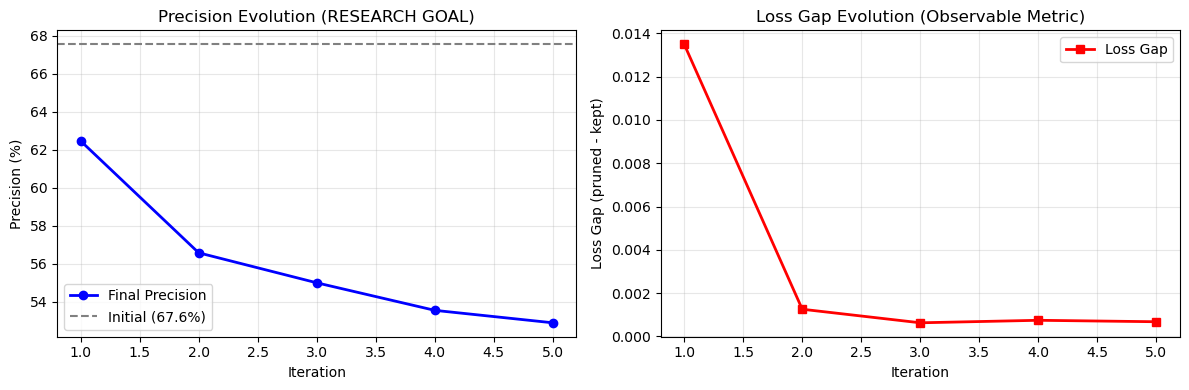

In [27]:
# =============================================================================
# LOSS-BASED ITERATIVE CYCLE (No precision knowledge required for decisions)
# =============================================================================
# Algorithm uses ONLY loss for decisions (simulates real-world)
# But we TRACK precision because that's our research goal
# =============================================================================
if not DO.lack_partial_coverage:
    print("=" * 70)
    print("LOSS-BASED ITERATIVE CYCLE")
    print("=" * 70)
    print("Decisions based on LOSS only (simulating real-world)")
    print("Tracking PRECISION as research metric")

    # Configuration
    n_iterations = 5
    prune_pct = 30  # Remove bottom 30% (highest loss) each iteration
    expand_pct = 20  # Add top 20% (lowest loss) from rejected pool

    # Initialize
    current_selection = set(top_sample_indices)  # Start with Iter1's top 30%
    rejected_pool = set(remaining_sample_indices)  # The 70% not selected
    partial_gids_set = set(anchor_data_iter1['partial_correct_gids'])

    # Track which gid is selected for each sample
    # Initialize from Iter1's selections
    sample_to_gid = {}
    for s in all_selections_iter1:
        sample_to_gid[s[2]] = s[3]

    # Track history
    history = []

    for iteration in range(n_iterations):
        print(f"\n{'='*60}")
        print(f"ITERATION {iteration + 1}")
        print(f"{'='*60}")

        n_current = len(current_selection)
        print(f"Current selection: {n_current} samples")

        # --- TRAIN MODEL on current selection + partial ---
        set_to_deterministic(rand_state + iteration + 100)

        model_cycle = HypothesisAmplifyingModel(
            n_shared_features=n_shared_features,
            n_hypothesis_features=n_hypothesis_features,
            shared_hidden=16, hypothesis_hidden=32, final_hidden=32,
            output_size=output_size
        )

        current_gids_set = set(sample_to_gid[idx] for idx in current_selection if idx in sample_to_gid)

        trainer_cycle = BiasedTrainer(
            DO, model_cycle,
            selected_gids=current_gids_set,
            partial_gids=partial_gids_set,
            partial_weight=partial_weight,
            lr=lr
        )

        # Train for 30 epochs
        print("Training model...")
        for epoch in range(30):
            trainer_cycle.train_epoch(dataloader, epoch, track_data=False)

        # --- SCORE current selection ---
        print("Scoring current selection...")
        scorer_current = RemainingDataScorer(DO, model_cycle, current_selection)
        scorer_current.compute_scores(dataloader, n_passes=5)
        analysis_current = scorer_current.get_analysis()

        # Compute loss scores for current selection
        current_scores = []
        for sample_idx in current_selection:
            gid = sample_to_gid.get(sample_idx)
            if gid and gid in analysis_current and analysis_current[gid]['avg_loss'] is not None:
                loss = analysis_current[gid]['avg_loss']
                is_correct = DO.df_train_hypothesis.iloc[gid]['correct_hypothesis']
                current_scores.append({
                    'sample_idx': sample_idx, 'gid': gid,
                    'loss': loss, 'is_correct': is_correct
                })

        # Sort by loss (ascending - lowest loss = keep, highest loss = prune)
        current_scores.sort(key=lambda x: x['loss'])

        # --- PRUNE: Remove highest loss samples ---
        n_prune = int(len(current_scores) * prune_pct / 100)
        kept = current_scores[:-n_prune] if n_prune > 0 else current_scores
        pruned = current_scores[-n_prune:] if n_prune > 0 else []

        avg_loss_kept = np.mean([s['loss'] for s in kept]) if kept else 0
        avg_loss_pruned = np.mean([s['loss'] for s in pruned]) if pruned else 0
        loss_gap = avg_loss_pruned - avg_loss_kept

        # Track precision (RESEARCH METRIC)
        prec_kept = sum(1 for s in kept if s['is_correct']) / len(kept) * 100 if kept else 0
        prec_pruned = sum(1 for s in pruned if s['is_correct']) / len(pruned) * 100 if pruned else 0

        print(f"PRUNE: Removing {n_prune} highest-loss samples")
        print(f"  Kept ({len(kept)}):   avg_loss={avg_loss_kept:.4f}  | precision={prec_kept:.1f}%")
        print(f"  Pruned ({len(pruned)}): avg_loss={avg_loss_pruned:.4f}  | precision={prec_pruned:.1f}%")
        print(f"  Loss gap: {loss_gap:.4f}")

        # Update selection
        pruned_samples = set(s['sample_idx'] for s in pruned)
        current_selection = current_selection - pruned_samples
        rejected_pool = rejected_pool | pruned_samples

        # --- SCORE rejected pool ---
        print("Scoring rejected pool...")
        scorer_rejected = RemainingDataScorer(DO, model_cycle, rejected_pool)
        scorer_rejected.compute_scores(dataloader, n_passes=5)
        analysis_rejected = scorer_rejected.get_analysis()

        # Find best (lowest loss) hypothesis per rejected sample
        rejected_scores = []
        for sample_idx in rejected_pool:
            start = sample_idx * hyp_per_sample
            best_loss = np.inf
            best_gid = None
            best_correct = False

            for hyp_idx in range(hyp_per_sample):
                gid = start + hyp_idx
                if gid in analysis_rejected and analysis_rejected[gid]['avg_loss'] is not None:
                    loss = analysis_rejected[gid]['avg_loss']
                    if loss < best_loss:
                        best_loss = loss
                        best_gid = gid
                        best_correct = DO.df_train_hypothesis.iloc[gid]['correct_hypothesis']

            if best_gid is not None:
                rejected_scores.append({
                    'sample_idx': sample_idx, 'gid': best_gid,
                    'loss': best_loss, 'is_correct': best_correct
                })

        # Sort by loss (ascending - lowest loss first)
        rejected_scores.sort(key=lambda x: x['loss'])

        # --- EXPAND: Add lowest loss samples from rejected pool ---
        n_expand = int(len(rejected_scores) * expand_pct / 100)
        to_add = rejected_scores[:n_expand]

        avg_loss_added = np.mean([s['loss'] for s in to_add]) if to_add else 0
        prec_added = sum(1 for s in to_add if s['is_correct']) / len(to_add) * 100 if to_add else 0

        print(f"EXPAND: Adding {len(to_add)} lowest-loss samples from rejected pool")
        print(f"  Added: avg_loss={avg_loss_added:.4f}  | precision={prec_added:.1f}%")

        # Update selection and gid mapping
        for s in to_add:
            current_selection.add(s['sample_idx'])
            sample_to_gid[s['sample_idx']] = s['gid']

        added_samples = set(s['sample_idx'] for s in to_add)
        rejected_pool = rejected_pool - added_samples

        # --- END OF ITERATION STATS ---
        n_final = len(current_selection)
        n_correct_final = sum(1 for idx in current_selection
                             if sample_to_gid.get(idx) and
                             DO.df_train_hypothesis.iloc[sample_to_gid[idx]]['correct_hypothesis'])
        prec_final = n_correct_final / n_final * 100 if n_final > 0 else 0

        print(f"\n>>> End of iteration {iteration + 1}:")
        print(f"    Selection: {n_final} samples, {n_correct_final} correct ({prec_final:.1f}% precision)")

        history.append({
            'iteration': iteration + 1,
            'n_samples': n_final,
            'n_correct': n_correct_final,
            'precision': prec_final,
            'loss_gap': loss_gap,
            'avg_loss_kept': avg_loss_kept,
            'avg_loss_pruned': avg_loss_pruned,
            'avg_loss_added': avg_loss_added,
            'prec_kept': prec_kept,
            'prec_pruned': prec_pruned,
            'prec_added': prec_added
        })

    # ==========================================================================
    # SUMMARY
    # ==========================================================================
    print(f"\n{'='*70}")
    print("ITERATION SUMMARY")
    print(f"{'='*70}")
    print(f"{'Iter':<6} {'Samples':<10} {'Correct':<10} {'Precision':<12} {'Loss Gap':<12}")
    print("-" * 50)
    print(f"{'Start':<6} {n_top:<10} {n_correct_top:<10} {precision_top*100:<12.1f}% {'N/A':<12}")
    for h in history:
        print(f"{h['iteration']:<6} {h['n_samples']:<10} {h['n_correct']:<10} {h['precision']:<12.1f}% {h['loss_gap']:<12.4f}")

    # Plot
    fig, axes = plt.subplots(1, 2, figsize=(12, 4))

    iterations = [h['iteration'] for h in history]

    ax1 = axes[0]
    ax1.plot(iterations, [h['precision'] for h in history], 'b-o', label='Final Precision', linewidth=2)
    ax1.axhline(y=precision_top*100, color='gray', linestyle='--', label=f'Initial ({precision_top*100:.1f}%)')
    ax1.set_xlabel('Iteration')
    ax1.set_ylabel('Precision (%)')
    ax1.set_title('Precision Evolution (RESEARCH GOAL)')
    ax1.legend()
    ax1.grid(True, alpha=0.3)

    ax2 = axes[1]
    ax2.plot(iterations, [h['loss_gap'] for h in history], 'r-s', label='Loss Gap', linewidth=2)
    ax2.set_xlabel('Iteration')
    ax2.set_ylabel('Loss Gap (pruned - kept)')
    ax2.set_title('Loss Gap Evolution (Observable Metric)')
    ax2.legend()
    ax2.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.savefig(f'{results_path}/iterative_cycle.png', dpi=150, bbox_inches='tight')
    plt.show()

---
# Corrected Iterative Cycle: Gradient-Based with Loss as Context

The previous loss-only approach failed (precision decreased from 67.6% to 52.9%).

**Correct approach:**
- Use **adaptive context selection** (gradient-only OR gradient+context per class)
- Include **LOSS** in the enriched context (alongside features)
- Classes with good gradient separation → use gradient-only
- Classes with poor gradient separation → use gradient + features + loss

In [31]:
def compute_anchor_data_with_loss(analysis, DO, loss_data):
    """
    Compute anchors that include loss in the enriched representation.
    
    For each class:
    - Compute gradient-only anchors (same as before)
    - Compute enriched anchors: gradient + features + normalized_loss
    - Decide which to use based on gradient anchor similarity
    """
    hyp_per_sample = DO.num_hyp_comb
    input_cols = DO.inpt_vars
    
    # Get partial data
    partial_correct_gids = set(DO.df_train_hypothesis[
        (DO.df_train_hypothesis['partial_full_info'] == 1) & 
        (DO.df_train_hypothesis['correct_hypothesis'] == True)
    ].index.tolist())
    blacklisted_gids = set(DO.df_train_hypothesis[
        (DO.df_train_hypothesis['partial_full_info'] == 1) & 
        (DO.df_train_hypothesis['correct_hypothesis'] == False)
    ].index.tolist())
    partial_sample_indices = set(gid // hyp_per_sample for gid in partial_correct_gids)
    
    # Storage
    anchor_correct_grad = {}
    anchor_incorrect_grad = {}
    anchor_correct_enriched = {}
    anchor_incorrect_enriched = {}
    anchor_similarity_grad = {}
    anchor_similarity_enriched = {}
    use_enriched = {}
    feature_norm_params = {}
    loss_norm_params = {}
    
    # Get gradient scale for normalization
    all_grads = [analysis[gid]['avg_gradient'] for gid in analysis 
                 if analysis[gid]['avg_gradient'] is not None]
    grad_scale = float(np.mean([np.linalg.norm(g) for g in all_grads])) if all_grads else 1.0
    
    for class_id in range(hyp_per_sample):
        class_correct_gids = [gid for gid in partial_correct_gids 
                              if DO.df_train_hypothesis.iloc[gid]['hyp_class_id'] == class_id]
        class_incorrect_gids = [gid for gid in blacklisted_gids 
                                if DO.df_train_hypothesis.iloc[gid]['hyp_class_id'] == class_id]
        
        # Collect data for correct hypotheses
        correct_grads, correct_features, correct_losses = [], [], []
        for gid in class_correct_gids:
            if gid in analysis and analysis[gid]['avg_gradient'] is not None and gid in loss_data:
                correct_grads.append(analysis[gid]['avg_gradient'])
                correct_features.append(DO.df_train_hypothesis.loc[gid, input_cols].values.astype(np.float64))
                correct_losses.append(loss_data[gid])
        
        # Collect data for incorrect hypotheses
        incorrect_grads, incorrect_features, incorrect_losses = [], [], []
        for gid in class_incorrect_gids:
            if gid in analysis and analysis[gid]['avg_gradient'] is not None and gid in loss_data:
                incorrect_grads.append(analysis[gid]['avg_gradient'])
                incorrect_features.append(DO.df_train_hypothesis.loc[gid, input_cols].values.astype(np.float64))
                incorrect_losses.append(loss_data[gid])
        
        if not correct_grads or not incorrect_grads:
            continue
        
        # Gradient-only anchors
        anchor_correct_grad[class_id] = np.mean(correct_grads, axis=0)
        anchor_incorrect_grad[class_id] = np.mean(incorrect_grads, axis=0)
        
        # Compute gradient-only anchor similarity
        sim_grad = float(np.dot(anchor_correct_grad[class_id], anchor_incorrect_grad[class_id]) / (
            np.linalg.norm(anchor_correct_grad[class_id]) * np.linalg.norm(anchor_incorrect_grad[class_id]) + 1e-8))
        anchor_similarity_grad[class_id] = sim_grad
        
        # Decide: use enriched if gradient anchor_similarity > 0
        use_enriched[class_id] = sim_grad > 0
        
        # Convert to arrays
        correct_grads = np.array(correct_grads, dtype=np.float64)
        incorrect_grads = np.array(incorrect_grads, dtype=np.float64)
        correct_features = np.array(correct_features, dtype=np.float64)
        incorrect_features = np.array(incorrect_features, dtype=np.float64)
        correct_losses = np.array(correct_losses, dtype=np.float64)
        incorrect_losses = np.array(incorrect_losses, dtype=np.float64)
        
        # Normalize features
        all_features = np.vstack([correct_features, incorrect_features])
        feat_mean = np.mean(all_features, axis=0)
        feat_std = np.std(all_features, axis=0) + 1e-8
        feature_norm_params[class_id] = {'mean': feat_mean, 'std': feat_std, 'scale': grad_scale}
        
        correct_features_norm = (correct_features - feat_mean) / feat_std * grad_scale
        incorrect_features_norm = (incorrect_features - feat_mean) / feat_std * grad_scale
        
        # Normalize losses
        all_losses = np.concatenate([correct_losses, incorrect_losses])
        loss_mean = np.mean(all_losses)
        loss_std = np.std(all_losses) + 1e-8
        loss_norm_params[class_id] = {'mean': loss_mean, 'std': loss_std, 'scale': grad_scale}
        
        # Negate loss: lower loss = higher value (more likely correct)
        correct_losses_norm = -((correct_losses - loss_mean) / loss_std) * grad_scale
        incorrect_losses_norm = -((incorrect_losses - loss_mean) / loss_std) * grad_scale
        
        # Enriched = gradient + features + loss
        correct_enriched = np.hstack([correct_grads, correct_features_norm, correct_losses_norm.reshape(-1, 1)])
        incorrect_enriched = np.hstack([incorrect_grads, incorrect_features_norm, incorrect_losses_norm.reshape(-1, 1)])
        
        anchor_correct_enriched[class_id] = np.mean(correct_enriched, axis=0)
        anchor_incorrect_enriched[class_id] = np.mean(incorrect_enriched, axis=0)
        
        # Compute enriched anchor similarity
        sim_enriched = float(np.dot(anchor_correct_enriched[class_id], anchor_incorrect_enriched[class_id]) / (
            np.linalg.norm(anchor_correct_enriched[class_id]) * np.linalg.norm(anchor_incorrect_enriched[class_id]) + 1e-8))
        anchor_similarity_enriched[class_id] = sim_enriched
    
    return {
        'anchor_correct_grad': anchor_correct_grad,
        'anchor_incorrect_grad': anchor_incorrect_grad,
        'anchor_correct_enriched': anchor_correct_enriched,
        'anchor_incorrect_enriched': anchor_incorrect_enriched,
        'anchor_similarity_grad': anchor_similarity_grad,
        'anchor_similarity_enriched': anchor_similarity_enriched,
        'use_enriched': use_enriched,
        'grad_scale': grad_scale,
        'feature_norm_params': feature_norm_params,
        'loss_norm_params': loss_norm_params,
        'partial_correct_gids': partial_correct_gids,
        'blacklisted_gids': blacklisted_gids,
        'partial_sample_indices': partial_sample_indices,
        'input_cols': input_cols
    }


def compute_adaptive_score_with_loss(gradient, features, loss, class_id, anchor_data):
    """
    Compute score using adaptive method with loss included in enriched context.
    
    - Gradient-only for classes with good gradient separation (anchor_sim < 0)
    - Enriched (gradient + features + loss) for classes with poor gradient separation
    """
    use_enriched = anchor_data['use_enriched'].get(class_id, False)
    
    if use_enriched:
        # Normalize features
        feat_params = anchor_data['feature_norm_params'].get(class_id)
        if feat_params:
            features_norm = (features - feat_params['mean']) / feat_params['std'] * feat_params['scale']
        else:
            features_norm = features
        
        # Normalize loss (negated: lower loss = higher value)
        loss_params = anchor_data['loss_norm_params'].get(class_id)
        if loss_params:
            loss_norm = -((loss - loss_params['mean']) / loss_params['std']) * loss_params['scale']
        else:
            loss_norm = -loss
        
        # Enriched = gradient + features + loss
        enriched = np.concatenate([gradient, features_norm, [loss_norm]])
        
        anchor_c = anchor_data['anchor_correct_enriched'].get(class_id)
        anchor_i = anchor_data['anchor_incorrect_enriched'].get(class_id)
    else:
        # Use gradient-only
        enriched = gradient
        anchor_c = anchor_data['anchor_correct_grad'].get(class_id)
        anchor_i = anchor_data['anchor_incorrect_grad'].get(class_id)
    
    if anchor_c is None:
        return 0.0
    
    sim_c = float(np.dot(enriched, anchor_c) / (np.linalg.norm(enriched) * np.linalg.norm(anchor_c) + 1e-8))
    sim_i = float(np.dot(enriched, anchor_i) / (np.linalg.norm(enriched) * np.linalg.norm(anchor_i) + 1e-8)) if anchor_i is not None else 0.0
    
    return sim_c - sim_i


print("Functions with loss context defined.")

Functions with loss context defined.


COMPARISON STUDY: GGH vs Partial-Only
Data splits: 72% train pool, 16% val, 12% test
  - Partial trains on: ~2.5% (partial data only, 100% correct)
  - GGH trains on: ~2.5% partial + ~15% selected (~73% correct)
Number of runs: 15
Training epochs: 200 (with validation-based epoch selection)

RUN 1/15 (rand_state=42)
Total: 1151 samples, 3453 hypotheses
Partial: 28 hypotheses (0.8%)

--- GGH Method ---


Scoring passes: 100%|██████████| 5/5 [00:00<00:00, 16.27it/s]


Scored 84 hypotheses from 28 samples


Scoring passes: 100%|██████████| 5/5 [00:01<00:00,  3.12it/s]


Scored 1008 hypotheses from 336 samples
GGH selection: 168 hypotheses at 55.4% precision
GGH trains on: 196 hypotheses (selection + partial)
Training GGH model (200 epochs)...
GGH: best_epoch=12, val_loss=0.0189, test_loss=0.0181, test_mae=0.1003, R2=0.3074

--- Partial Only ---
Partial trains on: 28 hypotheses (partial only)
Training Partial model (200 epochs)...
Partial: best_epoch=41, val_loss=0.0176, test_loss=0.0172, test_mae=0.0982, R2=0.3394

>>> Improvement: Loss=-0.0008, MAE=-0.0021, R2=-0.0320

RUN 2/15 (rand_state=142)
Total: 1151 samples, 3453 hypotheses
Partial: 28 hypotheses (0.8%)

--- GGH Method ---


Scoring passes: 100%|██████████| 5/5 [00:00<00:00, 16.38it/s]


Scored 84 hypotheses from 28 samples


Scoring passes: 100%|██████████| 5/5 [00:01<00:00,  3.12it/s]


Scored 1008 hypotheses from 336 samples
GGH selection: 168 hypotheses at 33.9% precision
GGH trains on: 196 hypotheses (selection + partial)
Training GGH model (200 epochs)...
GGH: best_epoch=3, val_loss=0.0178, test_loss=0.0189, test_mae=0.1061, R2=0.2253

--- Partial Only ---
Partial trains on: 28 hypotheses (partial only)
Training Partial model (200 epochs)...
Partial: best_epoch=4, val_loss=0.0179, test_loss=0.0194, test_mae=0.1102, R2=0.2048

>>> Improvement: Loss=+0.0005, MAE=+0.0041, R2=+0.0205

RUN 3/15 (rand_state=242)
Total: 1151 samples, 3453 hypotheses
Partial: 28 hypotheses (0.8%)

--- GGH Method ---


Scoring passes: 100%|██████████| 5/5 [00:00<00:00, 16.33it/s]


Scored 84 hypotheses from 28 samples


Scoring passes: 100%|██████████| 5/5 [00:01<00:00,  3.11it/s]


Scored 1008 hypotheses from 336 samples
GGH selection: 168 hypotheses at 41.1% precision
GGH trains on: 196 hypotheses (selection + partial)
Training GGH model (200 epochs)...
GGH: best_epoch=2, val_loss=0.0198, test_loss=0.0172, test_mae=0.1050, R2=0.2828

--- Partial Only ---
Partial trains on: 28 hypotheses (partial only)
Training Partial model (200 epochs)...
Partial: best_epoch=88, val_loss=0.0196, test_loss=0.0171, test_mae=0.1036, R2=0.2850

>>> Improvement: Loss=-0.0001, MAE=-0.0014, R2=-0.0022

RUN 4/15 (rand_state=342)
Total: 1151 samples, 3453 hypotheses
Partial: 28 hypotheses (0.8%)

--- GGH Method ---


Scoring passes: 100%|██████████| 5/5 [00:00<00:00, 16.36it/s]


Scored 84 hypotheses from 28 samples


Scoring passes: 100%|██████████| 5/5 [00:01<00:00,  3.12it/s]


Scored 1008 hypotheses from 336 samples
GGH selection: 168 hypotheses at 41.7% precision
GGH trains on: 196 hypotheses (selection + partial)
Training GGH model (200 epochs)...
GGH: best_epoch=2, val_loss=0.0159, test_loss=0.0161, test_mae=0.1028, R2=0.3087

--- Partial Only ---
Partial trains on: 28 hypotheses (partial only)
Training Partial model (200 epochs)...
Partial: best_epoch=97, val_loss=0.0210, test_loss=0.0187, test_mae=0.1101, R2=0.1972

>>> Improvement: Loss=+0.0026, MAE=+0.0073, R2=+0.1115

RUN 5/15 (rand_state=442)
Total: 1151 samples, 3453 hypotheses
Partial: 28 hypotheses (0.8%)

--- GGH Method ---


Scoring passes: 100%|██████████| 5/5 [00:00<00:00, 16.32it/s]


Scored 84 hypotheses from 28 samples


Scoring passes: 100%|██████████| 5/5 [00:01<00:00,  3.11it/s]


Scored 1008 hypotheses from 336 samples
GGH selection: 168 hypotheses at 34.5% precision
GGH trains on: 196 hypotheses (selection + partial)
Training GGH model (200 epochs)...
GGH: best_epoch=27, val_loss=0.0225, test_loss=0.0212, test_mae=0.1073, R2=0.1493

--- Partial Only ---
Partial trains on: 28 hypotheses (partial only)
Training Partial model (200 epochs)...
Partial: best_epoch=10, val_loss=0.0244, test_loss=0.0203, test_mae=0.1061, R2=0.1838

>>> Improvement: Loss=-0.0009, MAE=-0.0012, R2=-0.0345

RUN 6/15 (rand_state=542)
Total: 1151 samples, 3453 hypotheses
Partial: 28 hypotheses (0.8%)

--- GGH Method ---


Scoring passes: 100%|██████████| 5/5 [00:00<00:00, 16.31it/s]


Scored 84 hypotheses from 28 samples


Scoring passes: 100%|██████████| 5/5 [00:01<00:00,  3.12it/s]


Scored 1008 hypotheses from 336 samples
GGH selection: 168 hypotheses at 43.5% precision
GGH trains on: 196 hypotheses (selection + partial)
Training GGH model (200 epochs)...
GGH: best_epoch=42, val_loss=0.0160, test_loss=0.0185, test_mae=0.1093, R2=0.2280

--- Partial Only ---
Partial trains on: 28 hypotheses (partial only)
Training Partial model (200 epochs)...
Partial: best_epoch=52, val_loss=0.0174, test_loss=0.0194, test_mae=0.1114, R2=0.1901

>>> Improvement: Loss=+0.0009, MAE=+0.0021, R2=+0.0379

RUN 7/15 (rand_state=642)
Total: 1151 samples, 3453 hypotheses
Partial: 28 hypotheses (0.8%)

--- GGH Method ---


Scoring passes: 100%|██████████| 5/5 [00:00<00:00, 16.22it/s]


Scored 84 hypotheses from 28 samples


Scoring passes: 100%|██████████| 5/5 [00:01<00:00,  3.10it/s]


Scored 1008 hypotheses from 336 samples
GGH selection: 168 hypotheses at 69.6% precision
GGH trains on: 196 hypotheses (selection + partial)
Training GGH model (200 epochs)...
GGH: best_epoch=6, val_loss=0.0188, test_loss=0.0168, test_mae=0.0965, R2=0.2911

--- Partial Only ---
Partial trains on: 28 hypotheses (partial only)
Training Partial model (200 epochs)...
Partial: best_epoch=5, val_loss=0.0233, test_loss=0.0210, test_mae=0.1154, R2=0.1099

>>> Improvement: Loss=+0.0043, MAE=+0.0190, R2=+0.1811

RUN 8/15 (rand_state=742)
Total: 1151 samples, 3453 hypotheses
Partial: 28 hypotheses (0.8%)

--- GGH Method ---


Scoring passes: 100%|██████████| 5/5 [00:00<00:00, 16.27it/s]


Scored 84 hypotheses from 28 samples


Scoring passes: 100%|██████████| 5/5 [00:01<00:00,  3.10it/s]


Scored 1008 hypotheses from 336 samples
GGH selection: 168 hypotheses at 36.9% precision
GGH trains on: 196 hypotheses (selection + partial)
Training GGH model (200 epochs)...
GGH: best_epoch=14, val_loss=0.0201, test_loss=0.0196, test_mae=0.1117, R2=0.2450

--- Partial Only ---
Partial trains on: 28 hypotheses (partial only)
Training Partial model (200 epochs)...
Partial: best_epoch=41, val_loss=0.0192, test_loss=0.0185, test_mae=0.1102, R2=0.2889

>>> Improvement: Loss=-0.0011, MAE=-0.0015, R2=-0.0439

RUN 9/15 (rand_state=842)
Total: 1151 samples, 3453 hypotheses
Partial: 28 hypotheses (0.8%)

--- GGH Method ---


Scoring passes: 100%|██████████| 5/5 [00:00<00:00, 16.25it/s]


Scored 84 hypotheses from 28 samples


Scoring passes: 100%|██████████| 5/5 [00:01<00:00,  3.11it/s]


Scored 1008 hypotheses from 336 samples
GGH selection: 168 hypotheses at 71.4% precision
GGH trains on: 196 hypotheses (selection + partial)
Training GGH model (200 epochs)...
GGH: best_epoch=12, val_loss=0.0158, test_loss=0.0234, test_mae=0.1164, R2=0.2369

--- Partial Only ---
Partial trains on: 28 hypotheses (partial only)
Training Partial model (200 epochs)...
Partial: best_epoch=14, val_loss=0.0159, test_loss=0.0244, test_mae=0.1217, R2=0.2050

>>> Improvement: Loss=+0.0010, MAE=+0.0054, R2=+0.0319

RUN 10/15 (rand_state=942)
Total: 1151 samples, 3453 hypotheses
Partial: 28 hypotheses (0.8%)

--- GGH Method ---


Scoring passes: 100%|██████████| 5/5 [00:00<00:00, 16.35it/s]


Scored 84 hypotheses from 28 samples


Scoring passes: 100%|██████████| 5/5 [00:01<00:00,  3.11it/s]


Scored 1008 hypotheses from 336 samples
GGH selection: 168 hypotheses at 68.5% precision
GGH trains on: 196 hypotheses (selection + partial)
Training GGH model (200 epochs)...
GGH: best_epoch=5, val_loss=0.0146, test_loss=0.0221, test_mae=0.1142, R2=0.2314

--- Partial Only ---
Partial trains on: 28 hypotheses (partial only)
Training Partial model (200 epochs)...
Partial: best_epoch=6, val_loss=0.0169, test_loss=0.0240, test_mae=0.1214, R2=0.1681

>>> Improvement: Loss=+0.0018, MAE=+0.0072, R2=+0.0633

RUN 11/15 (rand_state=1042)
Total: 1151 samples, 3453 hypotheses
Partial: 28 hypotheses (0.8%)

--- GGH Method ---


Scoring passes: 100%|██████████| 5/5 [00:00<00:00, 16.36it/s]


Scored 84 hypotheses from 28 samples


Scoring passes: 100%|██████████| 5/5 [00:01<00:00,  3.11it/s]


Scored 1008 hypotheses from 336 samples
GGH selection: 168 hypotheses at 57.1% precision
GGH trains on: 196 hypotheses (selection + partial)
Training GGH model (200 epochs)...
GGH: best_epoch=1, val_loss=0.0208, test_loss=0.0213, test_mae=0.1126, R2=0.1140

--- Partial Only ---
Partial trains on: 28 hypotheses (partial only)
Training Partial model (200 epochs)...
Partial: best_epoch=3, val_loss=0.0224, test_loss=0.0229, test_mae=0.1148, R2=0.0496

>>> Improvement: Loss=+0.0015, MAE=+0.0023, R2=+0.0644

RUN 12/15 (rand_state=1142)
Total: 1151 samples, 3453 hypotheses
Partial: 28 hypotheses (0.8%)

--- GGH Method ---


Scoring passes: 100%|██████████| 5/5 [00:00<00:00, 16.30it/s]


Scored 84 hypotheses from 28 samples


Scoring passes: 100%|██████████| 5/5 [00:01<00:00,  3.12it/s]


Scored 1008 hypotheses from 336 samples
GGH selection: 168 hypotheses at 44.6% precision
GGH trains on: 196 hypotheses (selection + partial)
Training GGH model (200 epochs)...
GGH: best_epoch=67, val_loss=0.0189, test_loss=0.0189, test_mae=0.1049, R2=0.1909

--- Partial Only ---
Partial trains on: 28 hypotheses (partial only)
Training Partial model (200 epochs)...
Partial: best_epoch=86, val_loss=0.0199, test_loss=0.0228, test_mae=0.1204, R2=0.0234

>>> Improvement: Loss=+0.0039, MAE=+0.0155, R2=+0.1676

RUN 13/15 (rand_state=1242)
Total: 1151 samples, 3453 hypotheses
Partial: 28 hypotheses (0.8%)

--- GGH Method ---


Scoring passes: 100%|██████████| 5/5 [00:00<00:00, 16.31it/s]


Scored 84 hypotheses from 28 samples


Scoring passes: 100%|██████████| 5/5 [00:01<00:00,  3.11it/s]


Scored 1008 hypotheses from 336 samples
GGH selection: 168 hypotheses at 48.2% precision
GGH trains on: 196 hypotheses (selection + partial)
Training GGH model (200 epochs)...
GGH: best_epoch=154, val_loss=0.0225, test_loss=0.0195, test_mae=0.1153, R2=0.2096

--- Partial Only ---
Partial trains on: 28 hypotheses (partial only)
Training Partial model (200 epochs)...
Partial: best_epoch=32, val_loss=0.0223, test_loss=0.0196, test_mae=0.1125, R2=0.2037

>>> Improvement: Loss=+0.0001, MAE=-0.0028, R2=+0.0059

RUN 14/15 (rand_state=1342)
Total: 1151 samples, 3453 hypotheses
Partial: 28 hypotheses (0.8%)

--- GGH Method ---


Scoring passes: 100%|██████████| 5/5 [00:00<00:00, 16.35it/s]


Scored 84 hypotheses from 28 samples


Scoring passes: 100%|██████████| 5/5 [00:01<00:00,  3.10it/s]


Scored 1008 hypotheses from 336 samples
GGH selection: 168 hypotheses at 30.4% precision
GGH trains on: 196 hypotheses (selection + partial)
Training GGH model (200 epochs)...
GGH: best_epoch=26, val_loss=0.0182, test_loss=0.0153, test_mae=0.1039, R2=0.3306

--- Partial Only ---
Partial trains on: 28 hypotheses (partial only)
Training Partial model (200 epochs)...
Partial: best_epoch=192, val_loss=0.0241, test_loss=0.0240, test_mae=0.1330, R2=-0.0483

>>> Improvement: Loss=+0.0087, MAE=+0.0291, R2=+0.3789

RUN 15/15 (rand_state=1442)
Total: 1151 samples, 3453 hypotheses
Partial: 28 hypotheses (0.8%)

--- GGH Method ---


Scoring passes: 100%|██████████| 5/5 [00:00<00:00, 16.29it/s]


Scored 84 hypotheses from 28 samples


Scoring passes: 100%|██████████| 5/5 [00:01<00:00,  3.11it/s]


Scored 1008 hypotheses from 336 samples
GGH selection: 168 hypotheses at 56.0% precision
GGH trains on: 196 hypotheses (selection + partial)
Training GGH model (200 epochs)...
GGH: best_epoch=1, val_loss=0.0183, test_loss=0.0179, test_mae=0.1104, R2=0.3088

--- Partial Only ---
Partial trains on: 28 hypotheses (partial only)
Training Partial model (200 epochs)...
Partial: best_epoch=8, val_loss=0.0175, test_loss=0.0176, test_mae=0.1060, R2=0.3227

>>> Improvement: Loss=-0.0004, MAE=-0.0044, R2=-0.0139

COMPARISON STUDY RESULTS

Detailed Results:
Run   GGH Prec   GGH Loss     Partial Loss   Δ Loss     GGH R2     Part R2    Δ R2      
----------------------------------------------------------------------------------------------------
1     55.4      % 0.0181       0.0172            -0.0008 0.3074     0.3394        -0.0320
2     33.9      % 0.0189       0.0194            +0.0005 0.2253     0.2048        +0.0205
3     41.1      % 0.0172       0.0171            -0.0001 0.2828     0.2850    

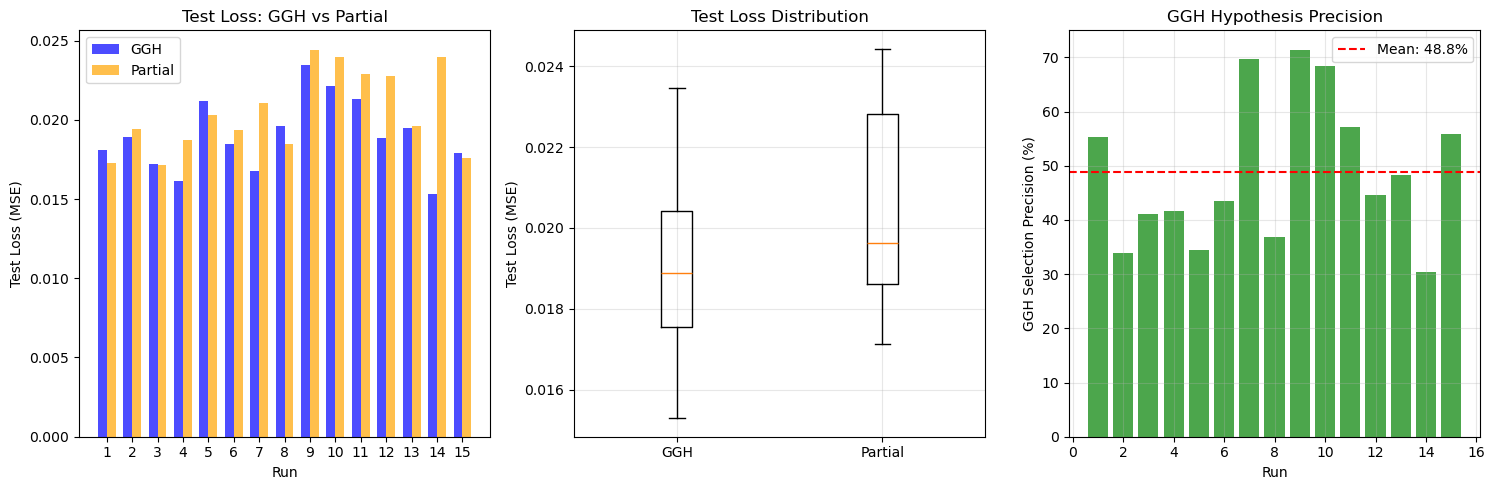


CONCLUSION
GGH significantly OUTPERFORMS Partial-only (p=0.0443)
Average improvement: 0.0015 MSE


In [41]:
# =============================================================================
# COMPARISON STUDY: GGH vs Partial-Only (15 Random States)
# =============================================================================
# Compare:
#   - GGH: Single-pass pruning (~73% precision) + partial (~2.5%)
#   - Partial: Partial data only (~2.5%)
# Both: 200 epochs, validation-based epoch selection, test evaluation
# =============================================================================
from scipy import stats
from torch.utils.data import TensorDataset, DataLoader

def create_dataloader_with_gids(DO, batch_size=32):
    """Create dataloader that includes global_ids."""
    input_cols = DO.inpt_vars + [var + '_hypothesis' for var in DO.miss_vars]
    n_samples = len(DO.df_train_hypothesis)
    global_ids = torch.arange(n_samples)
    
    dataset = TensorDataset(
        torch.tensor(DO.df_train_hypothesis[input_cols].values, dtype=torch.float32),
        torch.tensor(DO.df_train_hypothesis[DO.target_vars].values, dtype=torch.float32),
        global_ids
    )
    return DataLoader(dataset, batch_size=batch_size, shuffle=True)


def train_with_validation(DO, model, trainer_class, selected_gids, partial_gids, 
                          partial_weight, lr, n_epochs=200, batch_size=32):
    """
    Train model with validation-based epoch selection.
    Returns best model state, best epoch, and validation losses.
    """
    dataloader = create_dataloader_with_gids(DO, batch_size)
    
    # Initialize trainer
    trainer = trainer_class(DO, model, selected_gids=selected_gids, 
                           partial_gids=partial_gids, partial_weight=partial_weight, lr=lr)
    
    best_val_loss = float('inf')
    best_epoch = 0
    best_state = None
    val_losses = []
    
    for epoch in range(n_epochs):
        trainer.train_epoch(dataloader, epoch, track_data=False)
        
        # Evaluate on validation set
        model.eval()
        with torch.no_grad():
            val_inputs, val_targets = DO.get_validation_tensors(use_info="full info")
            val_preds = model(val_inputs)
            val_loss = torch.nn.functional.mse_loss(val_preds, val_targets).item()
        model.train()
        
        val_losses.append(val_loss)
        
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_epoch = epoch
            best_state = {k: v.clone() for k, v in model.state_dict().items()}
    
    # Restore best model
    model.load_state_dict(best_state)
    return model, best_epoch, val_losses, best_val_loss


def evaluate_on_test(DO, model):
    """Evaluate model on test set. Returns loss, MAE, and R2 score."""
    model.eval()
    with torch.no_grad():
        test_inputs, test_targets = DO.get_test_tensors(use_info="full info")
        test_preds = model(test_inputs)
        test_loss = torch.nn.functional.mse_loss(test_preds, test_targets).item()
        test_mae = torch.nn.functional.l1_loss(test_preds, test_targets).item()
        
        # Calculate R2 score
        ss_res = torch.sum((test_targets - test_preds) ** 2).item()
        ss_tot = torch.sum((test_targets - test_targets.mean()) ** 2).item()
        r2_score = 1 - (ss_res / ss_tot) if ss_tot > 0 else 0.0
    return test_loss, test_mae, r2_score


def run_ggh_single_pass(DO, rand_state, n_epochs_selection=30):
    """
    Run GGH single-pass pruning to get high-precision selection.
    Returns selected_gids and precision.
    """
    set_to_deterministic(rand_state)
    
    # Get data parameters
    hyp_per_sample = DO.num_hyp_comb
    n_samples = len(DO.df_train_hypothesis) // hyp_per_sample
    inpt_vars = DO.inpt_vars + [var + '_hypothesis' for var in DO.miss_vars]
    n_shared_features = len(DO.inpt_vars)
    n_hypothesis_features = len(DO.miss_vars)
    output_size = len(DO.target_vars)
    
    # Get partial data
    partial_correct_gids = set(DO.df_train_hypothesis[
        (DO.df_train_hypothesis['partial_full_info'] == 1) & 
        (DO.df_train_hypothesis['correct_hypothesis'] == True)
    ].index.tolist())
    partial_sample_indices = set(gid // hyp_per_sample for gid in partial_correct_gids)
    
    # Create dataloader with global_ids
    dataloader = create_dataloader_with_gids(DO, batch_size=32)
    
    # === STEP 1: Train unbiased model on all hypotheses ===
    model_unbiased = HypothesisAmplifyingModel(
        n_shared_features=n_shared_features,
        n_hypothesis_features=n_hypothesis_features,
        shared_hidden=16, hypothesis_hidden=32, final_hidden=32,
        output_size=output_size
    )
    trainer_unbiased = UnbiasedTrainer(DO, model_unbiased, lr=0.01)
    # Train with track_data=False for most epochs, then track_data=True for final epoch
    for epoch in range(n_epochs_selection - 1):
        trainer_unbiased.train_epoch(dataloader, epoch, track_data=False)
    # Final epoch with track_data=True to collect hypothesis analysis
    trainer_unbiased.train_epoch(dataloader, n_epochs_selection - 1, track_data=True)
    
    # === STEP 2: Use Adaptive Context Selection to get top 30% ===
    anchor_data = compute_anchor_data(trainer_unbiased, DO)
    all_selections, _ = select_hypotheses_adaptive(trainer_unbiased, DO, anchor_data)
    selections = all_selections.copy()  # Both point to same list structure
    
    # Get top 30%
    selections.sort(key=lambda x: x[0], reverse=True)
    top_30_pct = int(len(selections) * 0.30)
    top_selections = selections[:top_30_pct]
    top_sample_indices = set(s[2] for s in top_selections)
    
    # Track sample_to_gid
    sample_to_gid = {s[2]: s[3] for s in all_selections}
    
    # === STEP 3: Train biased model on top 30% + partial ===
    set_to_deterministic(rand_state + 100)
    model_biased = HypothesisAmplifyingModel(
        n_shared_features=n_shared_features,
        n_hypothesis_features=n_hypothesis_features,
        shared_hidden=16, hypothesis_hidden=32, final_hidden=32,
        output_size=output_size
    )
    
    top_gids_set = set(sample_to_gid[idx] for idx in top_sample_indices if idx in sample_to_gid)
    trainer_biased = BiasedTrainer(DO, model_biased, selected_gids=top_gids_set,
                                   partial_gids=partial_correct_gids, partial_weight=2.0, lr=0.01)
    for epoch in range(n_epochs_selection):
        trainer_biased.train_epoch(dataloader, epoch, track_data=False)
    
    # === STEP 4: Score top 30% with biased model, prune bottom 50% ===
    # First, score PARTIAL data to build anchors
    partial_scorer = RemainingDataScorer(DO, model_biased, partial_sample_indices)
    partial_scorer.compute_scores(dataloader, n_passes=5)
    partial_analysis = partial_scorer.get_analysis()
    
    # Build loss data for partial samples
    partial_loss_data = {gid: partial_analysis[gid]['avg_loss'] 
                        for gid in partial_analysis if partial_analysis[gid]['avg_loss'] is not None}
    
    # Compute anchors from PARTIAL data
    anchor_data_biased = compute_anchor_data_with_loss(partial_analysis, DO, partial_loss_data)
    
    # Now score top 30% samples
    scorer = RemainingDataScorer(DO, model_biased, top_sample_indices)
    scorer.compute_scores(dataloader, n_passes=5)
    analysis = scorer.get_analysis()
    
    
    # Score each sample using anchors from partial data
    scored_samples = []
    for sample_idx in top_sample_indices:
        gid = sample_to_gid.get(sample_idx)
        if not gid:
            continue
        if gid not in analysis:
            continue
        if analysis[gid]['avg_gradient'] is None:
            continue
        
        gradient = analysis[gid]['avg_gradient']
        loss = analysis[gid]['avg_loss']
        class_id = DO.df_train_hypothesis.iloc[gid]['hyp_class_id']
        features = DO.df_train_hypothesis.loc[gid, DO.inpt_vars].values.astype(np.float64)
        is_correct = DO.df_train_hypothesis.iloc[gid]['correct_hypothesis']
        
        score = compute_adaptive_score_with_loss(gradient, features, loss, class_id, anchor_data_biased)
        scored_samples.append({
            'sample_idx': sample_idx, 'gid': gid, 'score': score, 'is_correct': is_correct
        })
    
    
    # Sort and keep top 50% (prune bottom 50%)
    scored_samples.sort(key=lambda x: x['score'], reverse=True)
    n_keep = len(scored_samples) // 2
    kept_samples = scored_samples[:n_keep]
    
    # Calculate precision
    n_correct = sum(1 for s in kept_samples if s['is_correct'])
    precision = n_correct / len(kept_samples) * 100 if kept_samples else 0
    
    # Return selected gids
    selected_gids = set(s['gid'] for s in kept_samples)
    
    return selected_gids, precision, partial_correct_gids


# =============================================================================
# MAIN COMPARISON LOOP
# =============================================================================
print("=" * 80)
print("COMPARISON STUDY: GGH vs Partial-Only")
print("=" * 80)
print(f"Data splits: 72% train pool, 16% val, 12% test")
print(f"  - Partial trains on: ~2.5% (partial data only, 100% correct)")
print(f"  - GGH trains on: ~2.5% partial + ~15% selected (~73% correct)")
print(f"Number of runs: 15")
print(f"Training epochs: 200 (with validation-based epoch selection)")
print("=" * 80)

n_runs = 15
n_epochs = 200
results = []

for run_idx in range(n_runs):
    run_rand_state = 42 + run_idx * 100
    print(f"\n{'='*60}")
    print(f"RUN {run_idx + 1}/{n_runs} (rand_state={run_rand_state})")
    print(f"{'='*60}")
    
    # === Setup DataOperator with proper splits ===
    set_to_deterministic(run_rand_state)
    DO_run = DataOperator(
        data_path, inpt_vars, target_vars, miss_vars, hypothesis,
        partial_perc, run_rand_state, device='cpu',
        data_split={"train": 0.72, "val": 0.88}
    )
    DO_run.problem_type = 'regression'
    
    # Get dimensions
    hyp_per_sample = DO_run.num_hyp_comb
    n_shared_features = len(DO_run.inpt_vars)
    n_hypothesis_features = len(DO_run.miss_vars)
    output_size = len(DO_run.target_vars)
    
    # Get partial gids
    partial_gids = set(DO_run.df_train_hypothesis[
        (DO_run.df_train_hypothesis['partial_full_info'] == 1) & 
        (DO_run.df_train_hypothesis['correct_hypothesis'] == True)
    ].index.tolist())
    
    n_total_hyp = len(DO_run.df_train_hypothesis)
    n_samples = n_total_hyp // hyp_per_sample
    print(f"Total: {n_samples} samples, {n_total_hyp} hypotheses")
    print(f"Partial: {len(partial_gids)} hypotheses ({len(partial_gids)/n_total_hyp*100:.1f}%)")
    
    # === Method 1: GGH ===
    print("\n--- GGH Method ---")
    ggh_selected_gids, ggh_precision, _ = run_ggh_single_pass(DO_run, run_rand_state)
    print(f"GGH selection: {len(ggh_selected_gids)} hypotheses at {ggh_precision:.1f}% precision")
    print(f"GGH trains on: {len(ggh_selected_gids) + len(partial_gids)} hypotheses (selection + partial)")
    
    # Train GGH model
    set_to_deterministic(run_rand_state + 200)
    model_ggh = HypothesisAmplifyingModel(
        n_shared_features=n_shared_features,
        n_hypothesis_features=n_hypothesis_features,
        shared_hidden=16, hypothesis_hidden=32, final_hidden=32,
        output_size=output_size
    )
    
    print("Training GGH model (200 epochs)...")
    model_ggh, ggh_best_epoch, ggh_val_losses, ggh_best_val_loss = train_with_validation(
        DO_run, model_ggh, BiasedTrainer, 
        selected_gids=ggh_selected_gids, partial_gids=partial_gids,
        partial_weight=2.0, lr=0.01, n_epochs=n_epochs
    )
    
    ggh_test_loss, ggh_test_mae, ggh_test_r2 = evaluate_on_test(DO_run, model_ggh)
    print(f"GGH: best_epoch={ggh_best_epoch}, val_loss={ggh_best_val_loss:.4f}, test_loss={ggh_test_loss:.4f}, test_mae={ggh_test_mae:.4f}, R2={ggh_test_r2:.4f}")
    
    # === Method 2: Partial Only ===
    print("\n--- Partial Only ---")
    print(f"Partial trains on: {len(partial_gids)} hypotheses (partial only)")
    set_to_deterministic(run_rand_state + 300)
    model_partial = HypothesisAmplifyingModel(
        n_shared_features=n_shared_features,
        n_hypothesis_features=n_hypothesis_features,
        shared_hidden=16, hypothesis_hidden=32, final_hidden=32,
        output_size=output_size
    )
    
    print("Training Partial model (200 epochs)...")
    model_partial, partial_best_epoch, partial_val_losses, partial_best_val_loss = train_with_validation(
        DO_run, model_partial, BiasedTrainer,
        selected_gids=set(),  # No GGH selections, only partial
        partial_gids=partial_gids,
        partial_weight=1.0, lr=0.01, n_epochs=n_epochs
    )
    
    partial_test_loss, partial_test_mae, partial_test_r2 = evaluate_on_test(DO_run, model_partial)
    print(f"Partial: best_epoch={partial_best_epoch}, val_loss={partial_best_val_loss:.4f}, test_loss={partial_test_loss:.4f}, test_mae={partial_test_mae:.4f}, R2={partial_test_r2:.4f}")
    
    # === Record results ===
    results.append({
        'run': run_idx + 1,
        'rand_state': run_rand_state,
        'ggh_precision': ggh_precision,
        'ggh_n_selected': len(ggh_selected_gids),
        'ggh_best_epoch': ggh_best_epoch,
        'ggh_val_loss': ggh_best_val_loss,
        'ggh_test_loss': ggh_test_loss,
        'ggh_test_mae': ggh_test_mae,
        'partial_best_epoch': partial_best_epoch,
        'partial_val_loss': partial_best_val_loss,
        'partial_test_loss': partial_test_loss,
        'partial_test_mae': partial_test_mae,
        'improvement_loss': partial_test_loss - ggh_test_loss,
        'improvement_mae': partial_test_mae - ggh_test_mae,
        'ggh_test_r2': ggh_test_r2,
        'partial_test_r2': partial_test_r2,
        'improvement_r2': ggh_test_r2 - partial_test_r2
    })
    
    print(f"\n>>> Improvement: Loss={results[-1]['improvement_loss']:+.4f}, MAE={results[-1]['improvement_mae']:+.4f}, R2={results[-1]['improvement_r2']:+.4f}")

# =============================================================================
# SUMMARY
# =============================================================================
print(f"\n{'='*80}")
print("COMPARISON STUDY RESULTS")
print(f"{'='*80}")

# Create results DataFrame
df_results = pd.DataFrame(results)

# Print detailed table
print("\nDetailed Results:")
print(f"{'Run':<5} {'GGH Prec':<10} {'GGH Loss':<12} {'Partial Loss':<14} {'Δ Loss':<10} {'GGH R2':<10} {'Part R2':<10} {'Δ R2':<10}")
print("-" * 100)
for r in results:
    print(f"{r['run']:<5} {r['ggh_precision']:<10.1f}% {r['ggh_test_loss']:<12.4f} {r['partial_test_loss']:<14.4f} {r['improvement_loss']:+10.4f} {r['ggh_test_r2']:<10.4f} {r['partial_test_r2']:<10.4f} {r['improvement_r2']:+10.4f}")

# Summary statistics
print(f"\n{'='*80}")
print("SUMMARY STATISTICS")
print(f"{'='*80}")

ggh_losses = [r['ggh_test_loss'] for r in results]
partial_losses = [r['partial_test_loss'] for r in results]
ggh_maes = [r['ggh_test_mae'] for r in results]
partial_maes = [r['partial_test_mae'] for r in results]
ggh_r2s = [r['ggh_test_r2'] for r in results]
partial_r2s = [r['partial_test_r2'] for r in results]
ggh_precisions = [r['ggh_precision'] for r in results]

print(f"\nGGH Selection Precision: {np.mean(ggh_precisions):.1f}% ± {np.std(ggh_precisions):.1f}%")
print(f"\nTest Loss (MSE):")
print(f"  GGH:     {np.mean(ggh_losses):.4f} ± {np.std(ggh_losses):.4f}")
print(f"  Partial: {np.mean(partial_losses):.4f} ± {np.std(partial_losses):.4f}")

print(f"\nTest MAE:")
print(f"  GGH:     {np.mean(ggh_maes):.4f} ± {np.std(ggh_maes):.4f}")
print(f"  Partial: {np.mean(partial_maes):.4f} ± {np.std(partial_maes):.4f}")

print(f"\nTest R2 Score:")
print(f"  GGH:     {np.mean(ggh_r2s):.4f} ± {np.std(ggh_r2s):.4f}")
print(f"  Partial: {np.mean(partial_r2s):.4f} ± {np.std(partial_r2s):.4f}")

# Statistical tests (paired t-test)
t_stat_loss, p_value_loss = stats.ttest_rel(ggh_losses, partial_losses)
t_stat_mae, p_value_mae = stats.ttest_rel(ggh_maes, partial_maes)

print(f"\nStatistical Tests (paired t-test):")
print(f"  Loss: t={t_stat_loss:.3f}, p={p_value_loss:.4f} {'*' if p_value_loss < 0.05 else ''}")
print(f"  MAE:  t={t_stat_mae:.3f}, p={p_value_mae:.4f} {'*' if p_value_mae < 0.05 else ''}")
t_stat_r2, p_value_r2 = stats.ttest_rel(ggh_r2s, partial_r2s)
print(f"  R2:   t={t_stat_r2:.3f}, p={p_value_r2:.4f} {'*' if p_value_r2 < 0.05 else ''}")

# Win/Loss count
n_ggh_wins_loss = sum(1 for r in results if r['ggh_test_loss'] < r['partial_test_loss'])
n_ggh_wins_mae = sum(1 for r in results if r['ggh_test_mae'] < r['partial_test_mae'])
n_ggh_wins_r2 = sum(1 for r in results if r['ggh_test_r2'] > r['partial_test_r2'])
print(f"\nWin Rate:")
print(f"  GGH wins (Loss): {n_ggh_wins_loss}/{n_runs} ({n_ggh_wins_loss/n_runs*100:.1f}%)")
print(f"  GGH wins (MAE):  {n_ggh_wins_mae}/{n_runs} ({n_ggh_wins_mae/n_runs*100:.1f}%)")
print(f"  GGH wins (R2):   {n_ggh_wins_r2}/{n_runs} ({n_ggh_wins_r2/n_runs*100:.1f}%)")

# Plot
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Plot 1: Test Loss comparison
ax1 = axes[0]
x = np.arange(n_runs)
width = 0.35
ax1.bar(x - width/2, ggh_losses, width, label='GGH', color='blue', alpha=0.7)
ax1.bar(x + width/2, partial_losses, width, label='Partial', color='orange', alpha=0.7)
ax1.set_xlabel('Run')
ax1.set_ylabel('Test Loss (MSE)')
ax1.set_title('Test Loss: GGH vs Partial')
ax1.legend()
ax1.set_xticks(x)
ax1.set_xticklabels([str(i+1) for i in range(n_runs)])

# Plot 2: Box plot comparison
ax2 = axes[1]
bp = ax2.boxplot([ggh_losses, partial_losses], labels=['GGH', 'Partial'])
ax2.set_ylabel('Test Loss (MSE)')
ax2.set_title('Test Loss Distribution')
ax2.grid(True, alpha=0.3)

# Plot 3: GGH Precision across runs
ax3 = axes[2]
ax3.bar(range(1, n_runs+1), ggh_precisions, color='green', alpha=0.7)
ax3.axhline(y=np.mean(ggh_precisions), color='red', linestyle='--', label=f'Mean: {np.mean(ggh_precisions):.1f}%')
ax3.set_xlabel('Run')
ax3.set_ylabel('GGH Selection Precision (%)')
ax3.set_title('GGH Hypothesis Precision')
ax3.legend()
ax3.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(f'{results_path}/comparison_study_15runs.png', dpi=150, bbox_inches='tight')
plt.show()

# Final verdict
print(f"\n{'='*80}")
print("CONCLUSION")
print(f"{'='*80}")
avg_improvement = np.mean([r['improvement_loss'] for r in results])
if avg_improvement > 0 and p_value_loss < 0.05:
    print(f"GGH significantly OUTPERFORMS Partial-only (p={p_value_loss:.4f})")
    print(f"Average improvement: {avg_improvement:.4f} MSE")
elif avg_improvement < 0 and p_value_loss < 0.05:
    print(f"Partial-only significantly OUTPERFORMS GGH (p={p_value_loss:.4f})")
    print(f"GGH is worse by: {-avg_improvement:.4f} MSE")
else:
    print(f"No significant difference between methods (p={p_value_loss:.4f})")
    print(f"Average difference: {avg_improvement:+.4f} MSE")

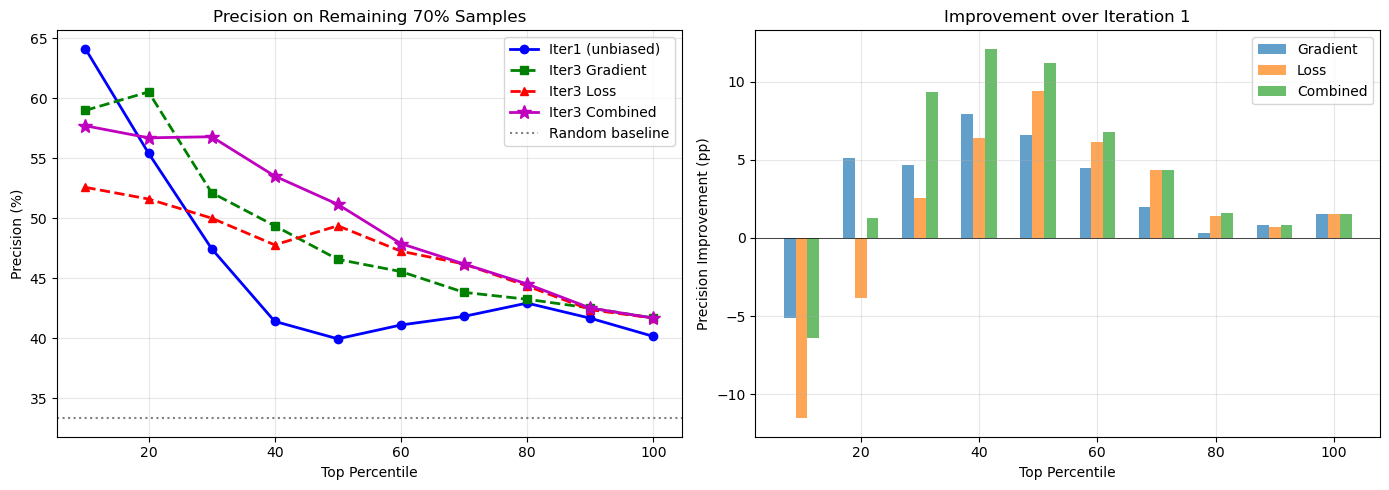


Plot saved to ../saved_results/Red Wine Hybrid Iterative/precision_comparison.png


In [28]:
if not DO.lack_partial_coverage:
    # Plot comparison
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    
    percentiles = [10, 20, 30, 40, 50, 60, 70, 80, 90, 100]
    
    # Plot 1: Precision comparison
    ax1 = axes[0]
    ax1.plot(percentiles, [iter1_remaining_precision.get(p, 0)*100 for p in percentiles], 
             'b-o', label='Iter1 (unbiased)', linewidth=2)
    ax1.plot(percentiles, [iter3_precision_grad.get(p, 0)*100 for p in percentiles], 
             'g--s', label='Iter3 Gradient', linewidth=2)
    ax1.plot(percentiles, [iter3_precision_loss.get(p, 0)*100 for p in percentiles], 
             'r--^', label='Iter3 Loss', linewidth=2)
    ax1.plot(percentiles, [iter3_precision_combined.get(p, 0)*100 for p in percentiles], 
             'm-*', label='Iter3 Combined', linewidth=2, markersize=10)
    ax1.axhline(y=100/hyp_per_sample, color='gray', linestyle=':', label='Random baseline')
    ax1.set_xlabel('Top Percentile')
    ax1.set_ylabel('Precision (%)')
    ax1.set_title('Precision on Remaining 70% Samples')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    # Plot 2: Improvement over Iteration 1
    ax2 = axes[1]
    improvement_grad = [iter3_precision_grad.get(p, 0)*100 - iter1_remaining_precision.get(p, 0)*100 for p in percentiles]
    improvement_loss = [iter3_precision_loss.get(p, 0)*100 - iter1_remaining_precision.get(p, 0)*100 for p in percentiles]
    improvement_combined = [iter3_precision_combined.get(p, 0)*100 - iter1_remaining_precision.get(p, 0)*100 for p in percentiles]
    
    ax2.bar([p-2 for p in percentiles], improvement_grad, width=2, label='Gradient', alpha=0.7)
    ax2.bar([p for p in percentiles], improvement_loss, width=2, label='Loss', alpha=0.7)
    ax2.bar([p+2 for p in percentiles], improvement_combined, width=2, label='Combined', alpha=0.7)
    ax2.axhline(y=0, color='black', linestyle='-', linewidth=0.5)
    ax2.set_xlabel('Top Percentile')
    ax2.set_ylabel('Precision Improvement (pp)')
    ax2.set_title('Improvement over Iteration 1')
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.savefig(f'{results_path}/precision_comparison.png', dpi=150, bbox_inches='tight')
    plt.show()
    
    print(f"\nPlot saved to {results_path}/precision_comparison.png")

CORRECTED ITERATIVE CYCLE (Gradient-Based with Loss as Context)

ITERATION 1
Start: 336 samples, 227 correct (67.6% precision)
Training model...
Scoring partial data for anchors...


Scoring passes: 100%|██████████| 5/5 [00:00<00:00, 18.02it/s]


Scored 84 hypotheses from 28 samples
Per-class method selection:
  Class 0: grad_sim=+0.999 (poor) -> ENRICHED+LOSS (sim=-0.113)
  Class 1: grad_sim=+0.983 (poor) -> ENRICHED+LOSS (sim=-0.761)
  Class 2: grad_sim=+0.996 (poor) -> ENRICHED+LOSS (sim=+0.056)
Scoring current selection...


Scoring passes: 100%|██████████| 5/5 [00:01<00:00,  2.96it/s]


Scored 1008 hypotheses from 336 samples

PRUNE: Removing 100 lowest-score samples
  Kept (236):   avg_score=1.0612  | precision=73.3%
  Pruned (100): avg_score=0.3915  | precision=54.0%
  Score gap: 0.6697

>>> End of iteration 1:
    Selection: 236 samples, 173 correct (73.3% precision)

ITERATION 2
Start: 236 samples, 173 correct (73.3% precision)
Training model...
Scoring partial data for anchors...


Scoring passes: 100%|██████████| 5/5 [00:00<00:00, 18.06it/s]


Scored 84 hypotheses from 28 samples
Per-class method selection:
  Class 0: grad_sim=+1.000 (poor) -> ENRICHED+LOSS (sim=-0.117)
  Class 1: grad_sim=+0.994 (poor) -> ENRICHED+LOSS (sim=-0.707)
  Class 2: grad_sim=+0.999 (poor) -> ENRICHED+LOSS (sim=+0.089)
Scoring current selection...


Scoring passes: 100%|██████████| 5/5 [00:01<00:00,  4.06it/s]


Scored 708 hypotheses from 236 samples

PRUNE: Removing 70 lowest-score samples
  Kept (166):   avg_score=1.1930  | precision=76.5%
  Pruned (70): avg_score=0.7787  | precision=65.7%
  Score gap: 0.4142

>>> End of iteration 2:
    Selection: 166 samples, 127 correct (76.5% precision)

ITERATION 3
Start: 166 samples, 127 correct (76.5% precision)
Training model...
Scoring partial data for anchors...


Scoring passes: 100%|██████████| 5/5 [00:00<00:00, 17.71it/s]


Scored 84 hypotheses from 28 samples
Per-class method selection:
  Class 0: grad_sim=+0.999 (poor) -> ENRICHED+LOSS (sim=-0.093)
  Class 1: grad_sim=+0.974 (poor) -> ENRICHED+LOSS (sim=-0.671)
  Class 2: grad_sim=+0.992 (poor) -> ENRICHED+LOSS (sim=-0.034)
Scoring current selection...


Scoring passes: 100%|██████████| 5/5 [00:00<00:00,  5.48it/s]


Scored 498 hypotheses from 166 samples

PRUNE: Removing 49 lowest-score samples
  Kept (117):   avg_score=1.2354  | precision=77.8%
  Pruned (49): avg_score=1.0245  | precision=73.5%
  Score gap: 0.2109

>>> End of iteration 3:
    Selection: 117 samples, 91 correct (77.8% precision)

ITERATION 4
Start: 117 samples, 91 correct (77.8% precision)
Training model...
Scoring partial data for anchors...


Scoring passes: 100%|██████████| 5/5 [00:00<00:00, 17.85it/s]


Scored 84 hypotheses from 28 samples
Per-class method selection:
  Class 0: grad_sim=+0.999 (poor) -> ENRICHED+LOSS (sim=-0.221)
  Class 1: grad_sim=+0.694 (poor) -> ENRICHED+LOSS (sim=-0.756)
  Class 2: grad_sim=+0.902 (poor) -> ENRICHED+LOSS (sim=-0.166)
Scoring current selection...


Scoring passes: 100%|██████████| 5/5 [00:00<00:00,  7.32it/s]


Scored 351 hypotheses from 117 samples

PRUNE: Removing 35 lowest-score samples
  Kept (82):   avg_score=1.3488  | precision=74.4%
  Pruned (35): avg_score=1.2112  | precision=85.7%
  Score gap: 0.1376

>>> End of iteration 4:
    Selection: 82 samples, 61 correct (74.4% precision)

ITERATION 5
Start: 82 samples, 61 correct (74.4% precision)
Training model...
Scoring partial data for anchors...


Scoring passes: 100%|██████████| 5/5 [00:00<00:00, 17.85it/s]


Scored 84 hypotheses from 28 samples
Per-class method selection:
  Class 0: grad_sim=+0.999 (poor) -> ENRICHED+LOSS (sim=-0.170)
  Class 1: grad_sim=+0.973 (poor) -> ENRICHED+LOSS (sim=-0.904)
  Class 2: grad_sim=+0.996 (poor) -> ENRICHED+LOSS (sim=+0.029)
Scoring current selection...


Scoring passes: 100%|██████████| 5/5 [00:00<00:00,  9.45it/s]


Scored 246 hypotheses from 82 samples

PRUNE: Removing 24 lowest-score samples
  Kept (58):   avg_score=1.3534  | precision=69.0%
  Pruned (24): avg_score=1.2615  | precision=87.5%
  Score gap: 0.0919

>>> End of iteration 5:
    Selection: 58 samples, 40 correct (69.0% precision)

ITERATION SUMMARY
Iter   Samples    Correct    Precision    Score Gap    Kept Prec    Pruned Prec 
--------------------------------------------------------------------------------
Start  336        227        67.6        % N/A         
1      236        173        73.3        % 0.6697       73.3        % 54.0        %
2      166        127        76.5        % 0.4142       76.5        % 65.7        %
3      117        91         77.8        % 0.2109       77.8        % 73.5        %
4      82         61         74.4        % 0.1376       74.4        % 85.7        %
5      58         40         69.0        % 0.0919       69.0        % 87.5        %


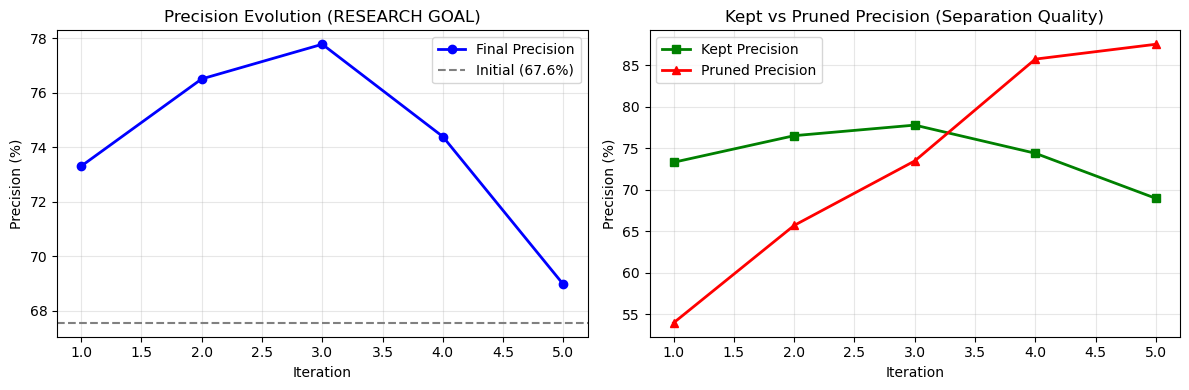

In [35]:
# =============================================================================
# CORRECTED ITERATIVE CYCLE: Gradient-Based with Loss as Context
# =============================================================================
# Uses adaptive context selection (gradient-only OR gradient+features+loss)
# Tracks precision as research metric, score gap as observable metric
# =============================================================================
if not DO.lack_partial_coverage:
    print("=" * 70)
    print("CORRECTED ITERATIVE CYCLE (Gradient-Based with Loss as Context)")
    print("=" * 70)

    # Configuration
    n_iterations = 5
    prune_pct = 30  # Remove bottom 30% by adaptive score each iteration
    expand_pct = 0  # No expansion for now (can enable later with small value like 5)

    # Initialize
    current_selection = set(top_sample_indices)  # Start with Iter1's top 30%
    rejected_pool = set(remaining_sample_indices)
    partial_gids_set = set(anchor_data_iter1['partial_correct_gids'])
    partial_sample_indices_set = anchor_data_iter1['partial_sample_indices']

    # Track which gid is selected for each sample (from Iter1)
    sample_to_gid = {}
    for s in all_selections_iter1:
        sample_to_gid[s[2]] = s[3]

    # Track history
    history = []

    for iteration in range(n_iterations):
        print(f"\n{'='*60}")
        print(f"ITERATION {iteration + 1}")
        print(f"{'='*60}")

        n_current = len(current_selection)
        n_correct_start = sum(1 for idx in current_selection
                              if sample_to_gid.get(idx) and
                              DO.df_train_hypothesis.iloc[sample_to_gid[idx]]['correct_hypothesis'])
        prec_start = n_correct_start / n_current * 100 if n_current > 0 else 0
        print(f"Start: {n_current} samples, {n_correct_start} correct ({prec_start:.1f}% precision)")

        # --- TRAIN MODEL on current selection + partial ---
        set_to_deterministic(rand_state + iteration + 200)

        model_cycle = HypothesisAmplifyingModel(
            n_shared_features=n_shared_features,
            n_hypothesis_features=n_hypothesis_features,
            shared_hidden=16, hypothesis_hidden=32, final_hidden=32,
            output_size=output_size
        )

        current_gids_set = set(sample_to_gid[idx] for idx in current_selection if idx in sample_to_gid)

        trainer_cycle = BiasedTrainer(
            DO, model_cycle,
            selected_gids=current_gids_set,
            partial_gids=partial_gids_set,
            partial_weight=partial_weight,
            lr=lr
        )

        print("Training model...")
        for epoch in range(30):
            trainer_cycle.train_epoch(dataloader, epoch, track_data=False)

        # --- SCORE partial data to build anchors ---
        print("Scoring partial data for anchors...")
        partial_scorer = RemainingDataScorer(DO, model_cycle, partial_sample_indices_set)
        partial_scorer.compute_scores(dataloader, n_passes=5)
        partial_analysis = partial_scorer.get_analysis()

        # Build loss_data dict for partial samples
        partial_loss_data = {gid: partial_analysis[gid]['avg_loss'] 
                            for gid in partial_analysis if partial_analysis[gid]['avg_loss'] is not None}

        # Compute anchors with loss
        anchor_data_cycle = compute_anchor_data_with_loss(partial_analysis, DO, partial_loss_data)

        # Print method selection
        print("Per-class method selection:")
        for class_id in range(hyp_per_sample):
            use_enr = anchor_data_cycle['use_enriched'].get(class_id, False)
            sim_grad = anchor_data_cycle['anchor_similarity_grad'].get(class_id, None)
            sim_enr = anchor_data_cycle['anchor_similarity_enriched'].get(class_id, None)
            if sim_grad is not None:
                if use_enr:
                    print(f"  Class {class_id}: grad_sim={sim_grad:+.3f} (poor) -> ENRICHED+LOSS (sim={sim_enr:+.3f})")
                else:
                    print(f"  Class {class_id}: grad_sim={sim_grad:+.3f} (good) -> GRADIENT-ONLY")

        # --- SCORE current selection ---
        print("Scoring current selection...")
        scorer_current = RemainingDataScorer(DO, model_cycle, current_selection)
        scorer_current.compute_scores(dataloader, n_passes=5)
        analysis_current = scorer_current.get_analysis()

        # Compute adaptive scores for current selection
        current_scores = []
        for sample_idx in current_selection:
            gid = sample_to_gid.get(sample_idx)
            if gid and gid in analysis_current and analysis_current[gid]['avg_gradient'] is not None:
                gradient = analysis_current[gid]['avg_gradient']
                loss = analysis_current[gid]['avg_loss']
                class_id = DO.df_train_hypothesis.iloc[gid]['hyp_class_id']
                features = DO.df_train_hypothesis.loc[gid, inpt_vars].values.astype(np.float64)
                is_correct = DO.df_train_hypothesis.iloc[gid]['correct_hypothesis']

                score = compute_adaptive_score_with_loss(gradient, features, loss, class_id, anchor_data_cycle)

                current_scores.append({
                    'sample_idx': sample_idx, 'gid': gid,
                    'score': score, 'loss': loss, 'is_correct': is_correct
                })

        # Sort by score (descending - highest score = keep, lowest score = prune)
        current_scores.sort(key=lambda x: x['score'], reverse=True)

        # --- PRUNE: Remove lowest score samples ---
        n_prune = int(len(current_scores) * prune_pct / 100)
        kept = current_scores[:-n_prune] if n_prune > 0 else current_scores
        pruned = current_scores[-n_prune:] if n_prune > 0 else []

        avg_score_kept = np.mean([s['score'] for s in kept]) if kept else 0
        avg_score_pruned = np.mean([s['score'] for s in pruned]) if pruned else 0
        score_gap = avg_score_kept - avg_score_pruned

        prec_kept = sum(1 for s in kept if s['is_correct']) / len(kept) * 100 if kept else 0
        prec_pruned = sum(1 for s in pruned if s['is_correct']) / len(pruned) * 100 if pruned else 0

        print(f"\nPRUNE: Removing {n_prune} lowest-score samples")
        print(f"  Kept ({len(kept)}):   avg_score={avg_score_kept:.4f}  | precision={prec_kept:.1f}%")
        print(f"  Pruned ({len(pruned)}): avg_score={avg_score_pruned:.4f}  | precision={prec_pruned:.1f}%")
        print(f"  Score gap: {score_gap:.4f}")

        # Update selection
        pruned_samples = set(s['sample_idx'] for s in pruned)
        current_selection = current_selection - pruned_samples
        rejected_pool = rejected_pool | pruned_samples

        # --- EXPAND (if enabled) ---
        if expand_pct > 0:
            print("\nScoring rejected pool for expansion...")
            scorer_rejected = RemainingDataScorer(DO, model_cycle, rejected_pool)
            scorer_rejected.compute_scores(dataloader, n_passes=5)
            analysis_rejected = scorer_rejected.get_analysis()

            # Find best hypothesis per rejected sample using adaptive score
            rejected_scores = []
            for sample_idx in rejected_pool:
                start = sample_idx * hyp_per_sample
                best_score = -np.inf
                best_gid = None
                best_correct = False

                for hyp_idx in range(hyp_per_sample):
                    gid = start + hyp_idx
                    if gid in analysis_rejected and analysis_rejected[gid]['avg_gradient'] is not None:
                        gradient = analysis_rejected[gid]['avg_gradient']
                        loss = analysis_rejected[gid]['avg_loss']
                        class_id = DO.df_train_hypothesis.iloc[gid]['hyp_class_id']
                        features = DO.df_train_hypothesis.loc[gid, inpt_vars].values.astype(np.float64)

                        score = compute_adaptive_score_with_loss(gradient, features, loss, class_id, anchor_data_cycle)

                        if score > best_score:
                            best_score = score
                            best_gid = gid
                            best_correct = DO.df_train_hypothesis.iloc[gid]['correct_hypothesis']

                if best_gid is not None:
                    rejected_scores.append({
                        'sample_idx': sample_idx, 'gid': best_gid,
                        'score': best_score, 'is_correct': best_correct
                    })

            # Sort and take top expand_pct%
            rejected_scores.sort(key=lambda x: x['score'], reverse=True)
            n_expand = int(len(rejected_scores) * expand_pct / 100)
            to_add = rejected_scores[:n_expand]

            prec_added = sum(1 for s in to_add if s['is_correct']) / len(to_add) * 100 if to_add else 0
            print(f"EXPAND: Adding {len(to_add)} highest-score samples | precision={prec_added:.1f}%")

            for s in to_add:
                current_selection.add(s['sample_idx'])
                sample_to_gid[s['sample_idx']] = s['gid']
            rejected_pool = rejected_pool - set(s['sample_idx'] for s in to_add)

        # --- END OF ITERATION STATS ---
        n_final = len(current_selection)
        n_correct_final = sum(1 for idx in current_selection
                             if sample_to_gid.get(idx) and
                             DO.df_train_hypothesis.iloc[sample_to_gid[idx]]['correct_hypothesis'])
        prec_final = n_correct_final / n_final * 100 if n_final > 0 else 0

        print(f"\n>>> End of iteration {iteration + 1}:")
        print(f"    Selection: {n_final} samples, {n_correct_final} correct ({prec_final:.1f}% precision)")

        history.append({
            'iteration': iteration + 1,
            'n_samples': n_final,
            'n_correct': n_correct_final,
            'precision': prec_final,
            'score_gap': score_gap,
            'prec_kept': prec_kept,
            'prec_pruned': prec_pruned
        })

    # ==========================================================================
    # SUMMARY
    # ==========================================================================
    print(f"\n{'='*70}")
    print("ITERATION SUMMARY")
    print(f"{'='*70}")
    print(f"{'Iter':<6} {'Samples':<10} {'Correct':<10} {'Precision':<12} {'Score Gap':<12} {'Kept Prec':<12} {'Pruned Prec':<12}")
    print("-" * 80)
    print(f"{'Start':<6} {n_top:<10} {n_correct_top:<10} {precision_top*100:<12.1f}% {'N/A':<12}")
    for h in history:
        print(f"{h['iteration']:<6} {h['n_samples']:<10} {h['n_correct']:<10} {h['precision']:<12.1f}% {h['score_gap']:<12.4f} {h['prec_kept']:<12.1f}% {h['prec_pruned']:<12.1f}%")

    # Plot
    fig, axes = plt.subplots(1, 2, figsize=(12, 4))
    iterations = [h['iteration'] for h in history]

    ax1 = axes[0]
    ax1.plot(iterations, [h['precision'] for h in history], 'b-o', label='Final Precision', linewidth=2)
    ax1.axhline(y=precision_top*100, color='gray', linestyle='--', label=f'Initial ({precision_top*100:.1f}%)')
    ax1.set_xlabel('Iteration')
    ax1.set_ylabel('Precision (%)')
    ax1.set_title('Precision Evolution (RESEARCH GOAL)')
    ax1.legend()
    ax1.grid(True, alpha=0.3)

    ax2 = axes[1]
    ax2.plot(iterations, [h['prec_kept'] for h in history], 'g-s', label='Kept Precision', linewidth=2)
    ax2.plot(iterations, [h['prec_pruned'] for h in history], 'r-^', label='Pruned Precision', linewidth=2)
    ax2.set_xlabel('Iteration')
    ax2.set_ylabel('Precision (%)')
    ax2.set_title('Kept vs Pruned Precision (Separation Quality)')
    ax2.legend()
    ax2.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.savefig(f'{results_path}/iterative_cycle_corrected.png', dpi=150, bbox_inches='tight')
    plt.show()

---
# Summary

In [ ]:
if not DO.lack_partial_coverage:
    print("=" * 70)
    print("ITERATIVE APPROACH SUMMARY")
    print("=" * 70)
    
    print(f"\nIteration 1: Unbiased Training")
    print(f"  - Trained on ALL hypotheses for {iter1_epochs} epochs")
    print(f"  - Top {top_percentile}% precision: {iter1_precision.get(top_percentile, 0)*100:.1f}%")
    print(f"  - Overall precision: {iter1_precision.get(100, 0)*100:.1f}%")
    
    print(f"\nIteration 2: Biased Training")
    print(f"  - Trained on top {top_percentile}% ({n_top} samples) + partial ({n_partial} samples)")
    print(f"  - Partial weight: {partial_weight:.2f}x")
    print(f"  - Training set was ~{precision_top*100:.1f}% correct (top selections) + 100% correct (partial)")
    
    print(f"\nIteration 3: Score Remaining Data")
    print(f"  - Scored {len(remaining_sample_indices)} remaining samples with biased model")
    print(f"  - Best method at top 30%:")
    
    p1_30 = iter1_remaining_precision.get(30, 0) * 100
    p3g_30 = iter3_precision_grad.get(30, 0) * 100
    p3l_30 = iter3_precision_loss.get(30, 0) * 100
    p3c_30 = iter3_precision_combined.get(30, 0) * 100
    
    print(f"    Iter1 unbiased: {p1_30:.1f}%")
    print(f"    Iter3 gradient: {p3g_30:.1f}% ({p3g_30 - p1_30:+.1f}pp)")
    print(f"    Iter3 loss:     {p3l_30:.1f}% ({p3l_30 - p1_30:+.1f}pp)")
    print(f"    Iter3 combined: {p3c_30:.1f}% ({p3c_30 - p1_30:+.1f}pp)")
    
    best_improvement = max(p3g_30, p3l_30, p3c_30) - p1_30
    if best_improvement > 0:
        print(f"\n  --> IMPROVEMENT: +{best_improvement:.1f} percentage points at top 30%")
    else:
        print(f"\n  --> No improvement at top 30% (need to investigate)")

## Next Steps

If Iteration 3 shows improvement:
1. **Continue iterating**: Add high-confidence Iter3 selections to training, retrain, repeat
2. **Tune loss_weight**: Try different weightings of loss vs gradient
3. **Final GGH**: Use the improved selections to feed into full GGH training and measure R2

If Iteration 3 shows no improvement:
1. **Investigate**: Check if biased model is truly biased (loss distribution on partial data)
2. **Try different percentiles**: Maybe top 20% or top 40% works better
3. **Alternative scoring**: Try other combinations of signals